In [10]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from fio import readin
from visualization import contour_generator
from tqdm import tqdm
import matplotlib as mpl
mpl.style.use('pof')

In [3]:
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/project_specific/windwave/')
from helper import RealWave

class Case():
    '''
    Class for each case. Initialization takes in the metadata like Bo, Re, ak etc.
    self.availt: The longest running time
    self.path: Path of the case file
    
    '''  
    def __init__(self, ustar, Retau, Bo, g, ak, LEVEL, emax, alterMU=1., L0=2*np.pi, k=4., h=1., OUTLEVEL=8,
                 working_dir='/home/jiarong/research/projects/turbulence/', prefix='curved_fixREtau_', PRINTWAVE=False, NOMATCH=True):
        '''
        alterMU: the altered MU ratio. Default 1. Turn on NOMATCH as well.
        self.N: output grid number
        '''
        # Register the metadata and spell the path
        self.ustar = ustar; self.ak = ak; self.Bo = Bo; self.Retau = Retau; self.alterMU = alterMU
        self.emax=0.3; self.LEVEL = LEVEL; self.N = 2**OUTLEVEL
        self.L0 = L0; self.g = g; self.k = k; self.h = h
        self.rho1 = 1; self.rho2 = 1.225/1000.; self.sigma = self.g/(self.Bo*self.k**2)
        self.mu2 = self.ustar*self.rho2*(self.L0-h)/self.Retau; self.mu1 = self.mu2/(18.31e-6/10.0e-4)/alterMU
        if NOMATCH == True:
            self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_MU%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.alterMU,self.LEVEL,self.emax) 
        else:
            self.path = working_dir + prefix + 'REtau%g_BO%g_g%g_ak%g_LEVEL%g_emax%g/' %(self.Retau,self.Bo,self.g,self.ak,self.LEVEL,self.emax) 
        # Run wave helper function to compute wave related info0
        # Notice that this depends on the definition of the wave in the specific set of cases
        self.wave = RealWave(g=self.g, sigma=self.sigma, rho=self.rho1, rho_air=self.rho2, mu = self.mu1, mu_air = self.mu2)
        self.wave.k2omega(self.k)
        
        # Detect the available time
#         for i in range (0,32*10):
#             exists = os.path.exists(self.path+'/matrix/u%g.dat' %(i/32.))
#             if not exists:
#                 self.availt = i
#                 break
        # Print out wave info; to double check, print the message file
        if PRINTWAVE:
            print(self.path)
            print("mu1 = %g, rho1 = %g, mu2 = %g, rho2 = %g, sigma = %g" %(self.mu1, self.rho1, self.mu2, self.rho2, self.sigma))
            print("Given k = %g (1/m), calculated omega = %g (1/s), period = %g (s), phase speed c = %g (m/s), wavelength = %g (m), Bo = %g" 
                  %(self.wave.k, self.wave.omega, 2*np.pi/self.wave.omega, self.wave.c, self.wave.wl, self.Bo))
            f = open(self.path+"message", "r")
            print(f.read())
    
    def eta_series(self, nframe, tstart, dt=1, PRUNING=True):
        '''
        This function reads in a eta time series and create a Eta object for each time.
        Input:
            nframe: Number of total frames.
            tstart: The starting time.
            dt: Time interval between each read-in.
            PRUNING: If eta is output by multiple processes and have multiple headers
            (might become obsolete).
        Output:
            self.energy_t: energy (std(eta)**2) time series (scalar)
            self.interface_t: time series of Interface object       
        '''       
        self.t = np.zeros(nframe)
        self.energy_t = []
        self.interface_t = [] 
        for i in tqdm (range (0,nframe)):
            self.t[i] = tstart+i*dt
            interface = Interface(self.L0, self.N, self.path, self.t[i], PRUNING=PRUNING)
            self.interface_t.append(interface)
            self.energy_t.append(np.std(interface.eta_tile)**2)      
        self.energy_t = np.array(self.energy_t)
    
    def mean_profile(self, time):
        NSLICE = 256
        NGRID = self.N
        self.yarray = np.linspace(0,self.L0,self.N,endpoint=False)+self.L0/2**self.N/2
        self.ux_ensemble = []
        for t in time:
            ux_3D = [] # axis0 in z, axis1 in x, axis2 in y  (in the code)
            for i in range (0,NSLICE-1):
                filename = self.path + 'field/ux_t%g_slice%g' % (t,i)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                ux = snapshot[:,0:NGRID].astype(np.float)
                ux_3D.append(ux)
            ux_3D = np.array(ux_3D)
            ux_aver = np.zeros(NGRID)
            # Slice in x,z(y) plane and average
            for i in range(0,NGRID):
                ux_aver[i] = np.average(ux_3D[:,:,i])
            self.ux_ensemble.append(ux_aver)
        self.ux_ensemble_aver = np.average(np.array(self.ux_ensemble), axis = 0)
#     def field(time):       

In [4]:
from scipy.interpolate import griddata
import gc
class Interface():
    '''
    Class for every interface related output. Unstructured grid.   
    '''  
    def __init__(self, L0, N, path, t, PRUNING=True):
        '''
        Input:
            L0, N: The desired output grid number
            working_dir: The case's directory
            t: Time of this eta file.
            PRUNING: If eta is output by multiple processes and have multiple headers
                    (might become obsolete).    
        Output:
            self.eta_tile: 2D interpolated eta
            self.p: 2D interpolated surface pressure
            self.tau: 2D interpolated surface viscous stress
        '''
        self.L0 = L0; self.N = N; self.t = t
        xarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 #Centered grid
        zarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 #size of self.N*self.N
        x_tile, z_tile = np.meshgrid(xarray,zarray)
        filename = path + 'eta/eta_t%g' %self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        if PRUNING:
            snapshot = snapshot[snapshot.x != 'x']
            snapshot = snapshot.astype('float')
            snapshot = snapshot[snapshot.pos < 1 + 0.4/4] # Exclude data over slope 0.4
        # Interpolate over x-z plane
        xdata = np.array(snapshot.x, dtype=float); zdata = np.array(snapshot.z, dtype=float); 
        etadata = np.array(snapshot.pos, dtype=float); 
        del (snapshot); gc.collect()        
        self.eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='nearest')

In [ ]:
case1 = Case(ustar=0.25, Retau=360, Bo=200, g=0.25, ak=0.2, LEVEL=10, emax=0.3, alterMU=64, NOMATCH=True, PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_')
case1.eta_series(nframe=15, tstart=76, dt=1)

In [ ]:
case2 = Case(ustar=0.25, Retau=360, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=32, NOMATCH=True, PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_')
case2.eta_series(nframe=12, tstart=76, dt=1, PRUNING = False)

In [ ]:
case3 = Case(ustar=0.25, Retau=360, Bo=200, g=4, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_')
case3.eta_series(nframe=13, tstart=76, dt=1)

In [6]:
case4 = Case(ustar=0.25, Retau=720, Bo=200, g=1, ak=0.2, LEVEL=10, emax=0.3, alterMU=16, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_boundary_')
case4.eta_series(nframe=43, tstart=58, dt=2)

  0%|          | 0/43 [00:00<?, ?it/s]

/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/
mu1 = 7.67063e-06, rho1 = 1, mu2 = 2.24719e-06, rho2 = 0.001225, sigma = 0.0003125
Given k = 4 (1/m), calculated omega = 2.00499 (1/s), period = 3.13377 (s), phase speed c = 0.501248 (m/s), wavelength = 1.5708 (m), Bo = 200
g = 1, c = 0.501248, Ustar = 0.25, MURATIO = 0.01831, mu_w = 7.67063e-06, rho_w = 1, mu_a = 2.24719e-06, rho_a = 0.001225, sigma = 0.0003125, Bo = 200, RE = 102646, Re_tau = 720
RELEASETIME = 57, uemax = 0.075 
slurmstepd: error: *** STEP 6249387.0 ON tiger-h24c2n7 CANCELLED AT 2021-04-18T06:03:50 DUE TO TIME LIMIT ***
srun: Job step aborted: Waiting up to 47 seconds for job step to finish.



 37%|███▋      | 16/43 [01:13<02:04,  4.62s/it]


ParserError: Error tokenizing data. C error: Expected 6 fields in line 1230311, saw 15


In [53]:
case5 = Case(ustar=0.25, Retau=720, Bo=200, g=4, ak=0.2, LEVEL=10, emax=0.3, alterMU=8, NOMATCH=True, 
             PRINTWAVE=True, OUTLEVEL=9, prefix='curved_fixREtau_boundary_')
case5.eta_series(nframe=15, tstart=58, dt=2)

  0%|          | 0/15 [00:00<?, ?it/s]

/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/
mu1 = 1.53413e-05, rho1 = 1, mu2 = 2.24719e-06, rho2 = 0.001225, sigma = 0.00125
Given k = 4 (1/m), calculated omega = 4.00999 (1/s), period = 1.56688 (s), phase speed c = 1.0025 (m/s), wavelength = 1.5708 (m), Bo = 200
g = 4, c = 1.0025, Ustar = 0.25, MURATIO = 0.01831, mu_w = 1.53413e-05, rho_w = 1, mu_a = 2.24719e-06, rho_a = 0.001225, sigma = 0.00125, Bo = 200, RE = 102646, Re_tau = 720
RELEASETIME = 57, uemax = 0.075 
srun: Job step aborted: Waiting up to 47 seconds for job step to finish.
slurmstepd: error: *** STEP 6251153.0 ON tiger-h21c2n21 CANCELLED AT 2021-04-19T06:24:06 DUE TO TIME LIMIT ***



100%|██████████| 15/15 [00:52<00:00,  3.52s/it]


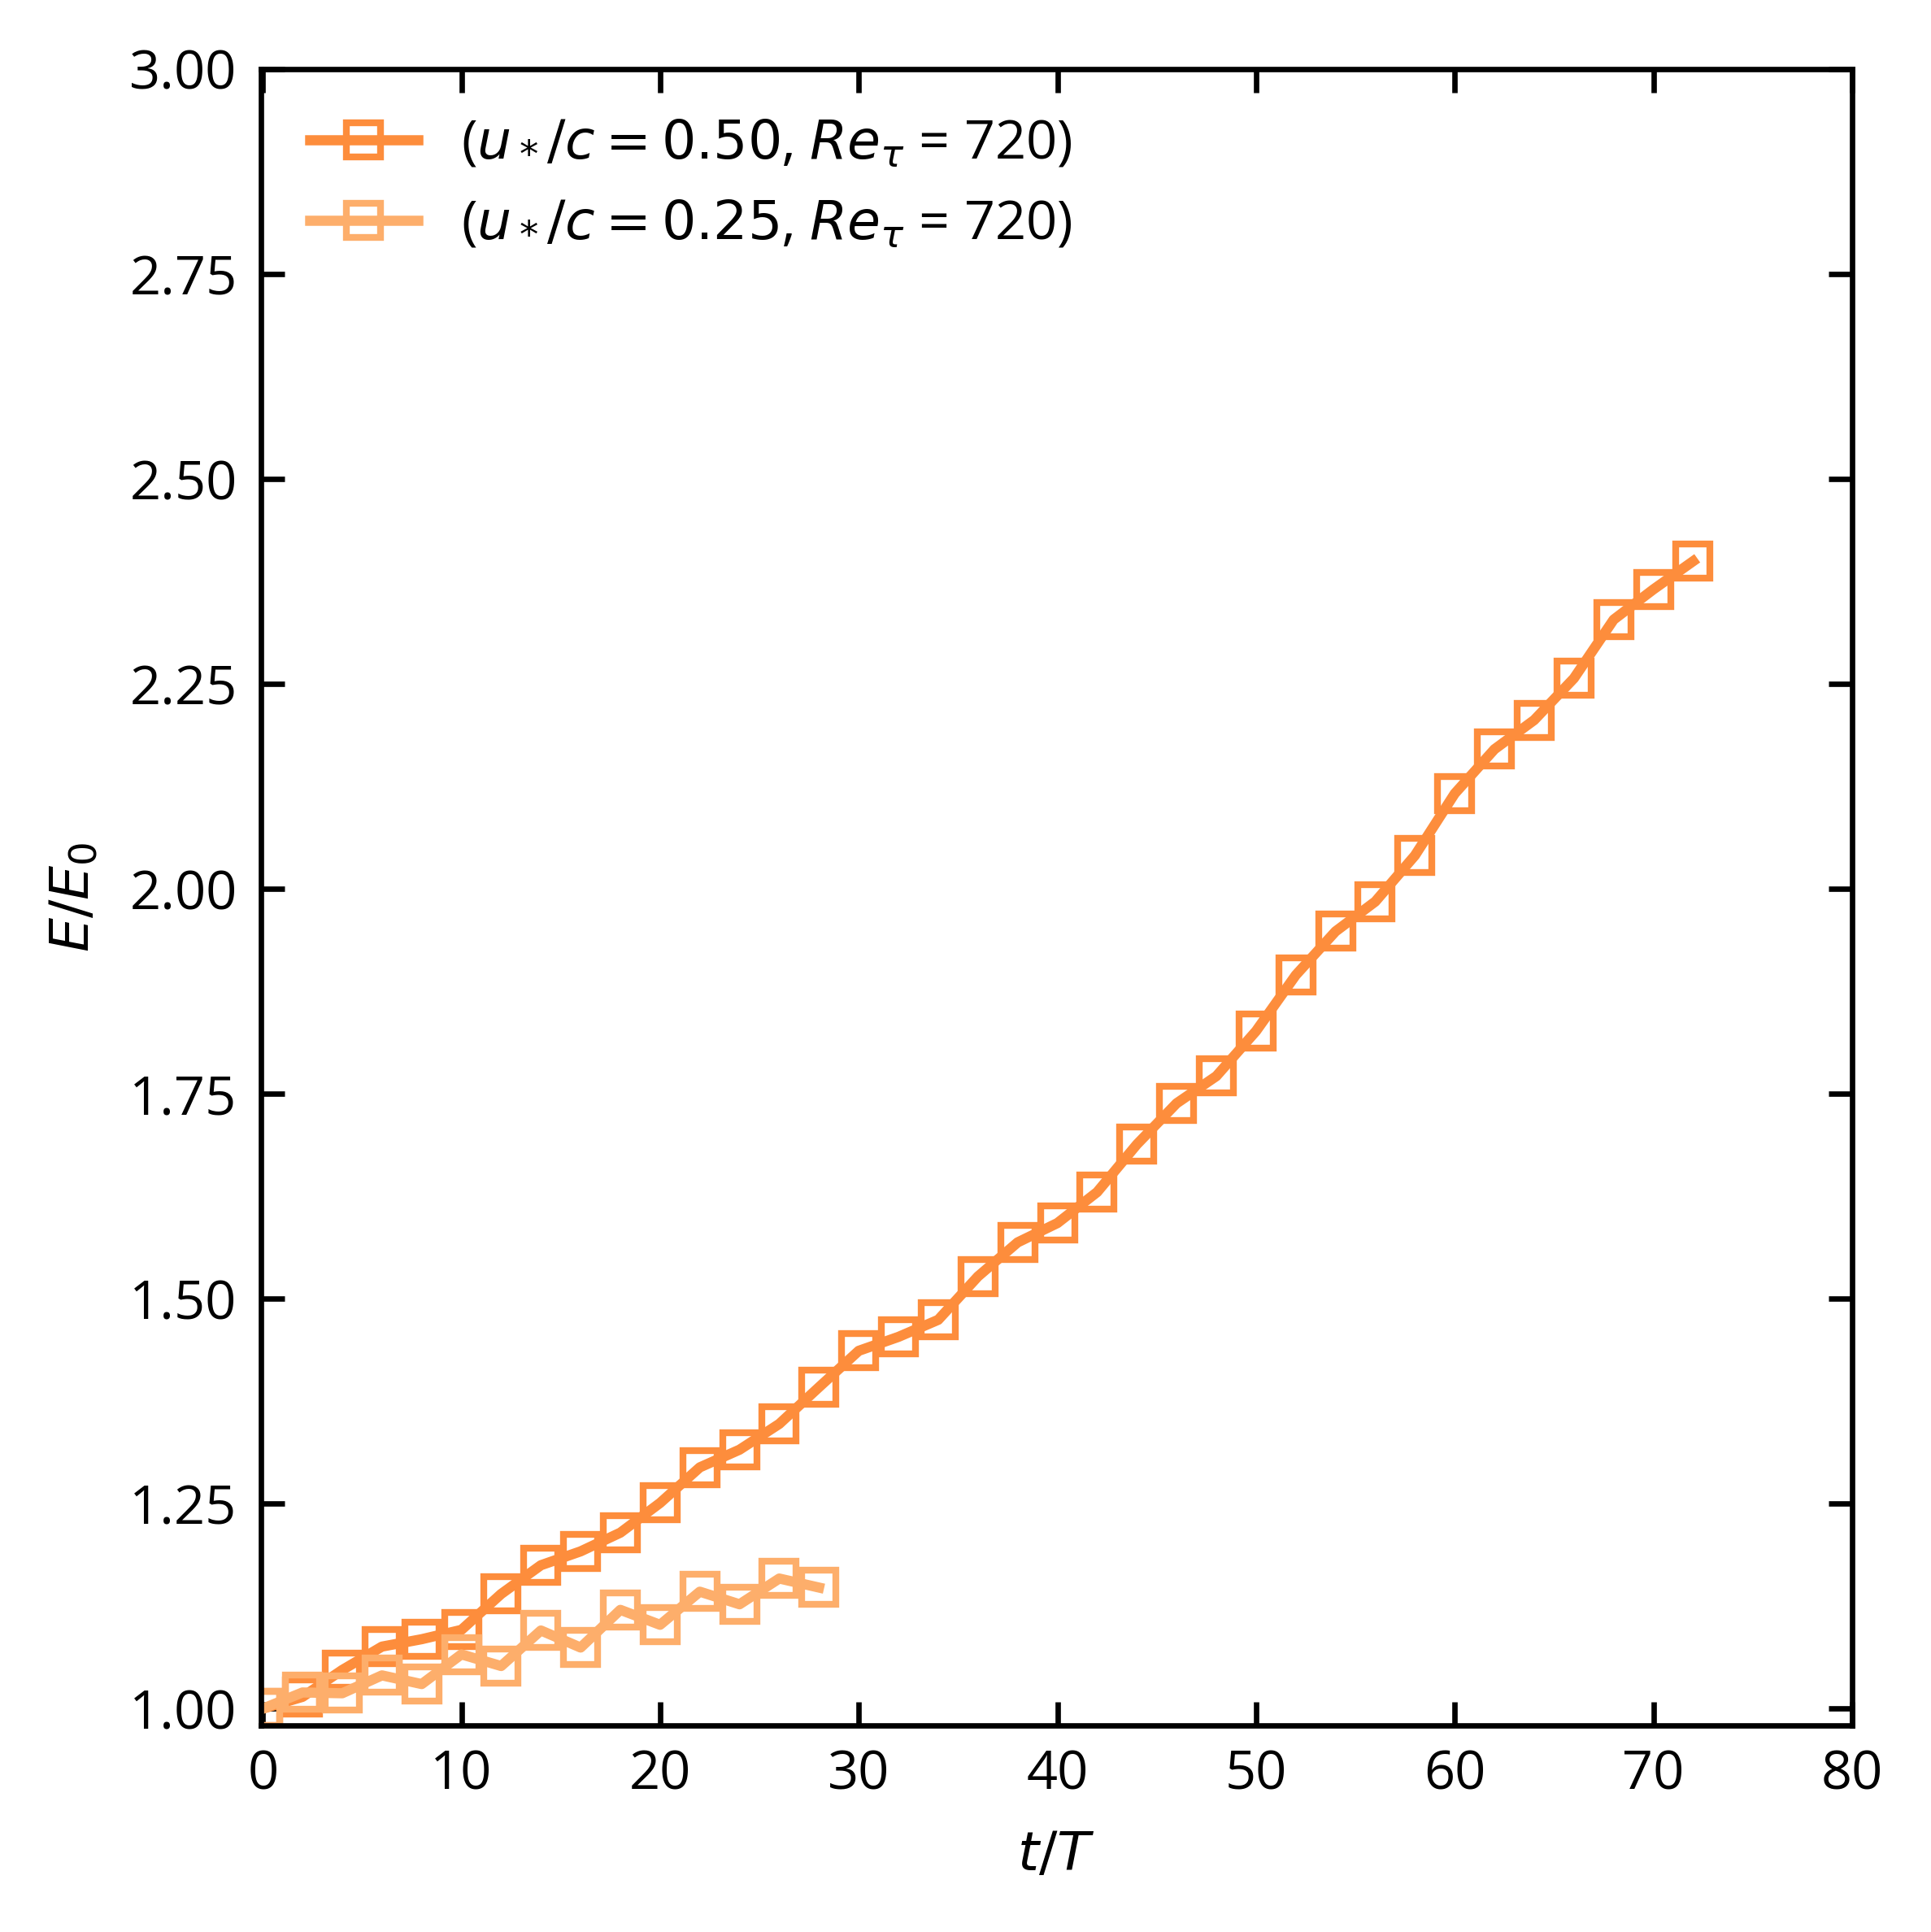

In [178]:
'''Energy plot'''
plt.figure(figsize=[4,4])

# for (i,case) in enumerate([case1,case2,case3]):
#     Tstart = 75
#     case.wave.Re(L0 = 2*np.pi)
#     plt.plot((case.t-Tstart)/(2*np.pi/case.wave.omega), case.energy_t/case.energy_t[0], label = r'($u_*/c=%.2f$, $Re_{\tau}$ = %.f)' %(case.ustar/case.wave.c, case.Retau), 
#              marker='o', mfc='none', markeredgewidth=1, markersize=5, color=plt.get_cmap('tab20c')(4+i)) 
for (i,case) in enumerate([case4]):
    Tstart = 58
    case.wave.Re(L0 = 2*np.pi)
    plt.plot((case.t-Tstart), case.energy_t/case.energy_t[0], label = r'($u_*/c=%.2f$, $Re_{\tau}$ = %.f)' %(case.ustar/case.wave.c, case.Retau), 
             marker='s', mfc='none', markeredgewidth=1, markersize=5, color=plt.get_cmap('tab20c')(4+i+1)) 
for (i,case) in enumerate([case5]):
    Tstart = 58
    case.wave.Re(L0 = 2*np.pi)
    plt.plot((case.t-Tstart), case.energy_t/case.energy_t[0], label = r'($u_*/c=%.2f$, $Re_{\tau}$ = %.f)' %(case.ustar/case.wave.c, case.Retau), 
             marker='s', mfc='none', markeredgewidth=1, markersize=5, color=plt.get_cmap('tab20c')(4+i+2)) 
plt.xlabel(r'$t/T$'); plt.ylabel(r'$E/E_0$'); plt.ylim([0.98,3]); plt.xlim([-0.1,80])
plt.legend(loc='upper left')
#     plt.title('Wave Energy ($u_*/c=%.2f$, $Re_w$ = %.f)' %(case.ustar/case.wave.c, case.wave.Re_wave*2))
# wa, wb = np.polyfit((case.t-Tstart)/(2*np.pi/case.wave.omega), np.log(case.energy_t/case.energy_t[0]), 1)
# plt.plot((case.t-Tstart)/(2*np.pi/case.wave.omega), np.exp(wa*(case.t-Tstart)/(2*np.pi/case.wave.omega)+wb), '--')
# print(wa/2/np.pi)
# print(wa/2/np.pi+4*(case.wave.c*case.L0/4/case.wave.Re_wave)*case.wave.k**2/case.wave.omega)

In [19]:
''' 2D eta detailed plots '''
path = '/home/jiarong/research/projects/turbulence/curved_fixREtau_boundary_REtau720_BO200_g4_ak0_MU8_LEVEL10_emax0.3/'
filename = path + 'eta/eta_t%g' %78
snapshot = pd.read_table(filename, delimiter = ',')
snapshot = snapshot[snapshot.x != 'x']
snapshot = snapshot.astype('float')
snapshot = snapshot[snapshot.pos < 1+ 0.4/4]

L0 = np.pi*2.; N = 512
xarray = np.linspace(-L0/2.,L0/2.,N,endpoint=False)+L0/2**N/2 #Centered grid
zarray = np.linspace(-L0/2.,L0/2.,N,endpoint=False)+L0/2**N/2 #size of self.N*self.N
x_tile, z_tile = np.meshgrid(xarray,zarray)

xdata = np.array(snapshot.x); zdata = np.array(snapshot.z); etadata = np.array(snapshot.pos)
eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='nearest')
eta = np.average(eta_tile, axis=0)  
# eta_var = np.std(eta_tile)**2
# energy_t.append(eta_var)
# eta_t.append(eta)          

(-25.55, 536.55, -0.061473366963957284, 0.08379228713760384)

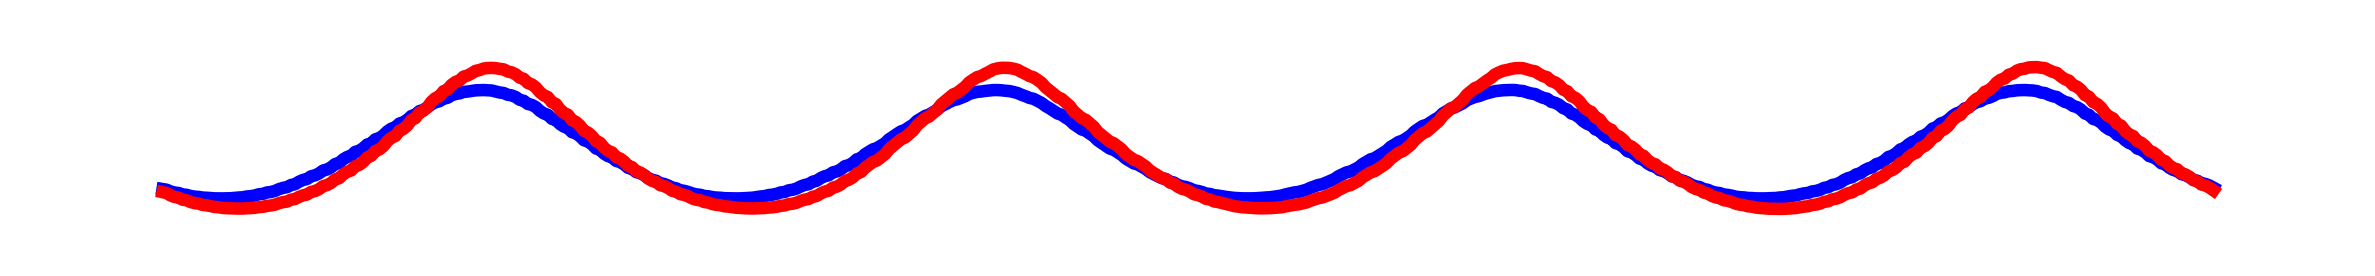

In [130]:
eta2 = np.average(eta_tile, axis = 0)
plt.figure(figsize=[4,0.5])
plt.plot(eta1-np.average(eta1), label = 't = 0T', c = 'blue')
plt.plot(eta2-np.average(eta2), label = 't = 9T', c = 'red')
plt.axis('off')

(-0.4, 0.4)

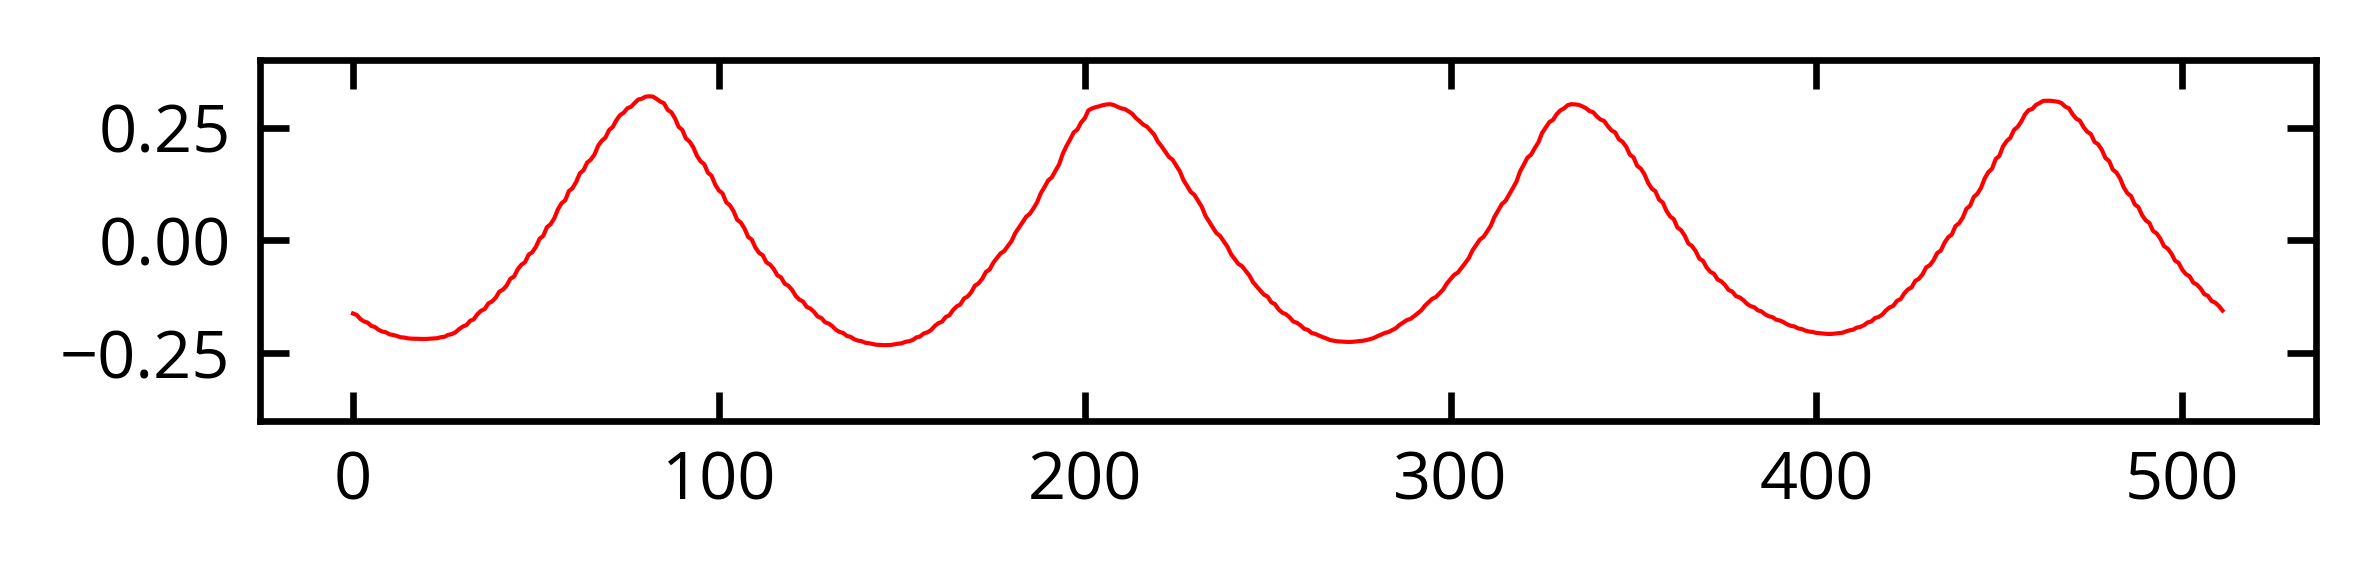

In [76]:
""" 2D eta spectral analysis """


In [70]:
np.max(eta_tile-1)*4

0.33755999999999986

In [146]:
case4.interface_t[20].__dict__

{'L0': 6.283185307179586,
 'N': 512,
 't': 98.0,
 'eta_tile': array([[1.07046, 1.06986, 1.06733, ..., 1.07224, 1.0721 , 1.07137],
        [1.07062, 1.07001, 1.06747, ..., 1.07238, 1.07224, 1.07152],
        [1.07087, 1.07024, 1.06761, ..., 1.07273, 1.07256, 1.07181],
        ...,
        [1.06946, 1.06875, 1.06608, ..., 1.07195, 1.07163, 1.07058],
        [1.06959, 1.06893, 1.06635, ..., 1.07182, 1.07155, 1.07061],
        [1.07009, 1.06948, 1.06696, ..., 1.07199, 1.07182, 1.07104]])}

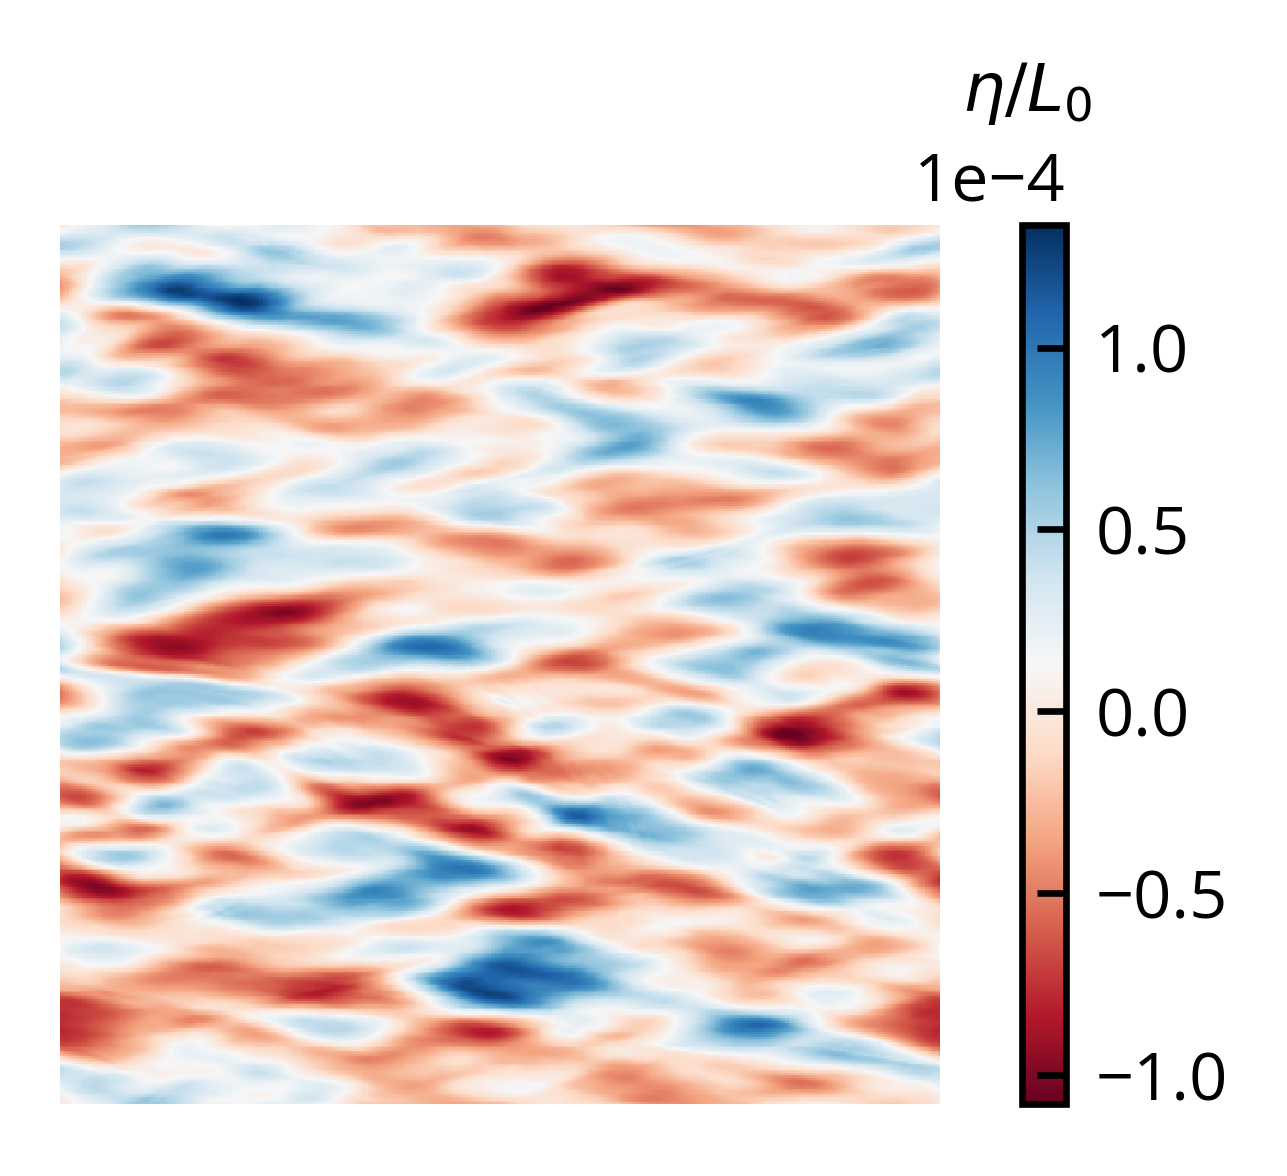

In [20]:
# eta_tile = case4.interface_t[20].eta_tile
plt.figure(figsize=[3,2])
plt.imshow((eta_tile-1)/2/np.pi, cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi])
plt.axis('off')
ax = plt.gca()
ax.text(1.1,1.15, r'$\eta/L_0$', ha='center', va='center', transform=ax.transAxes)
plt.colorbar()

/home/jiarong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


Text(0.5, 1.0, 'Difference between t = 0 and t = 70')

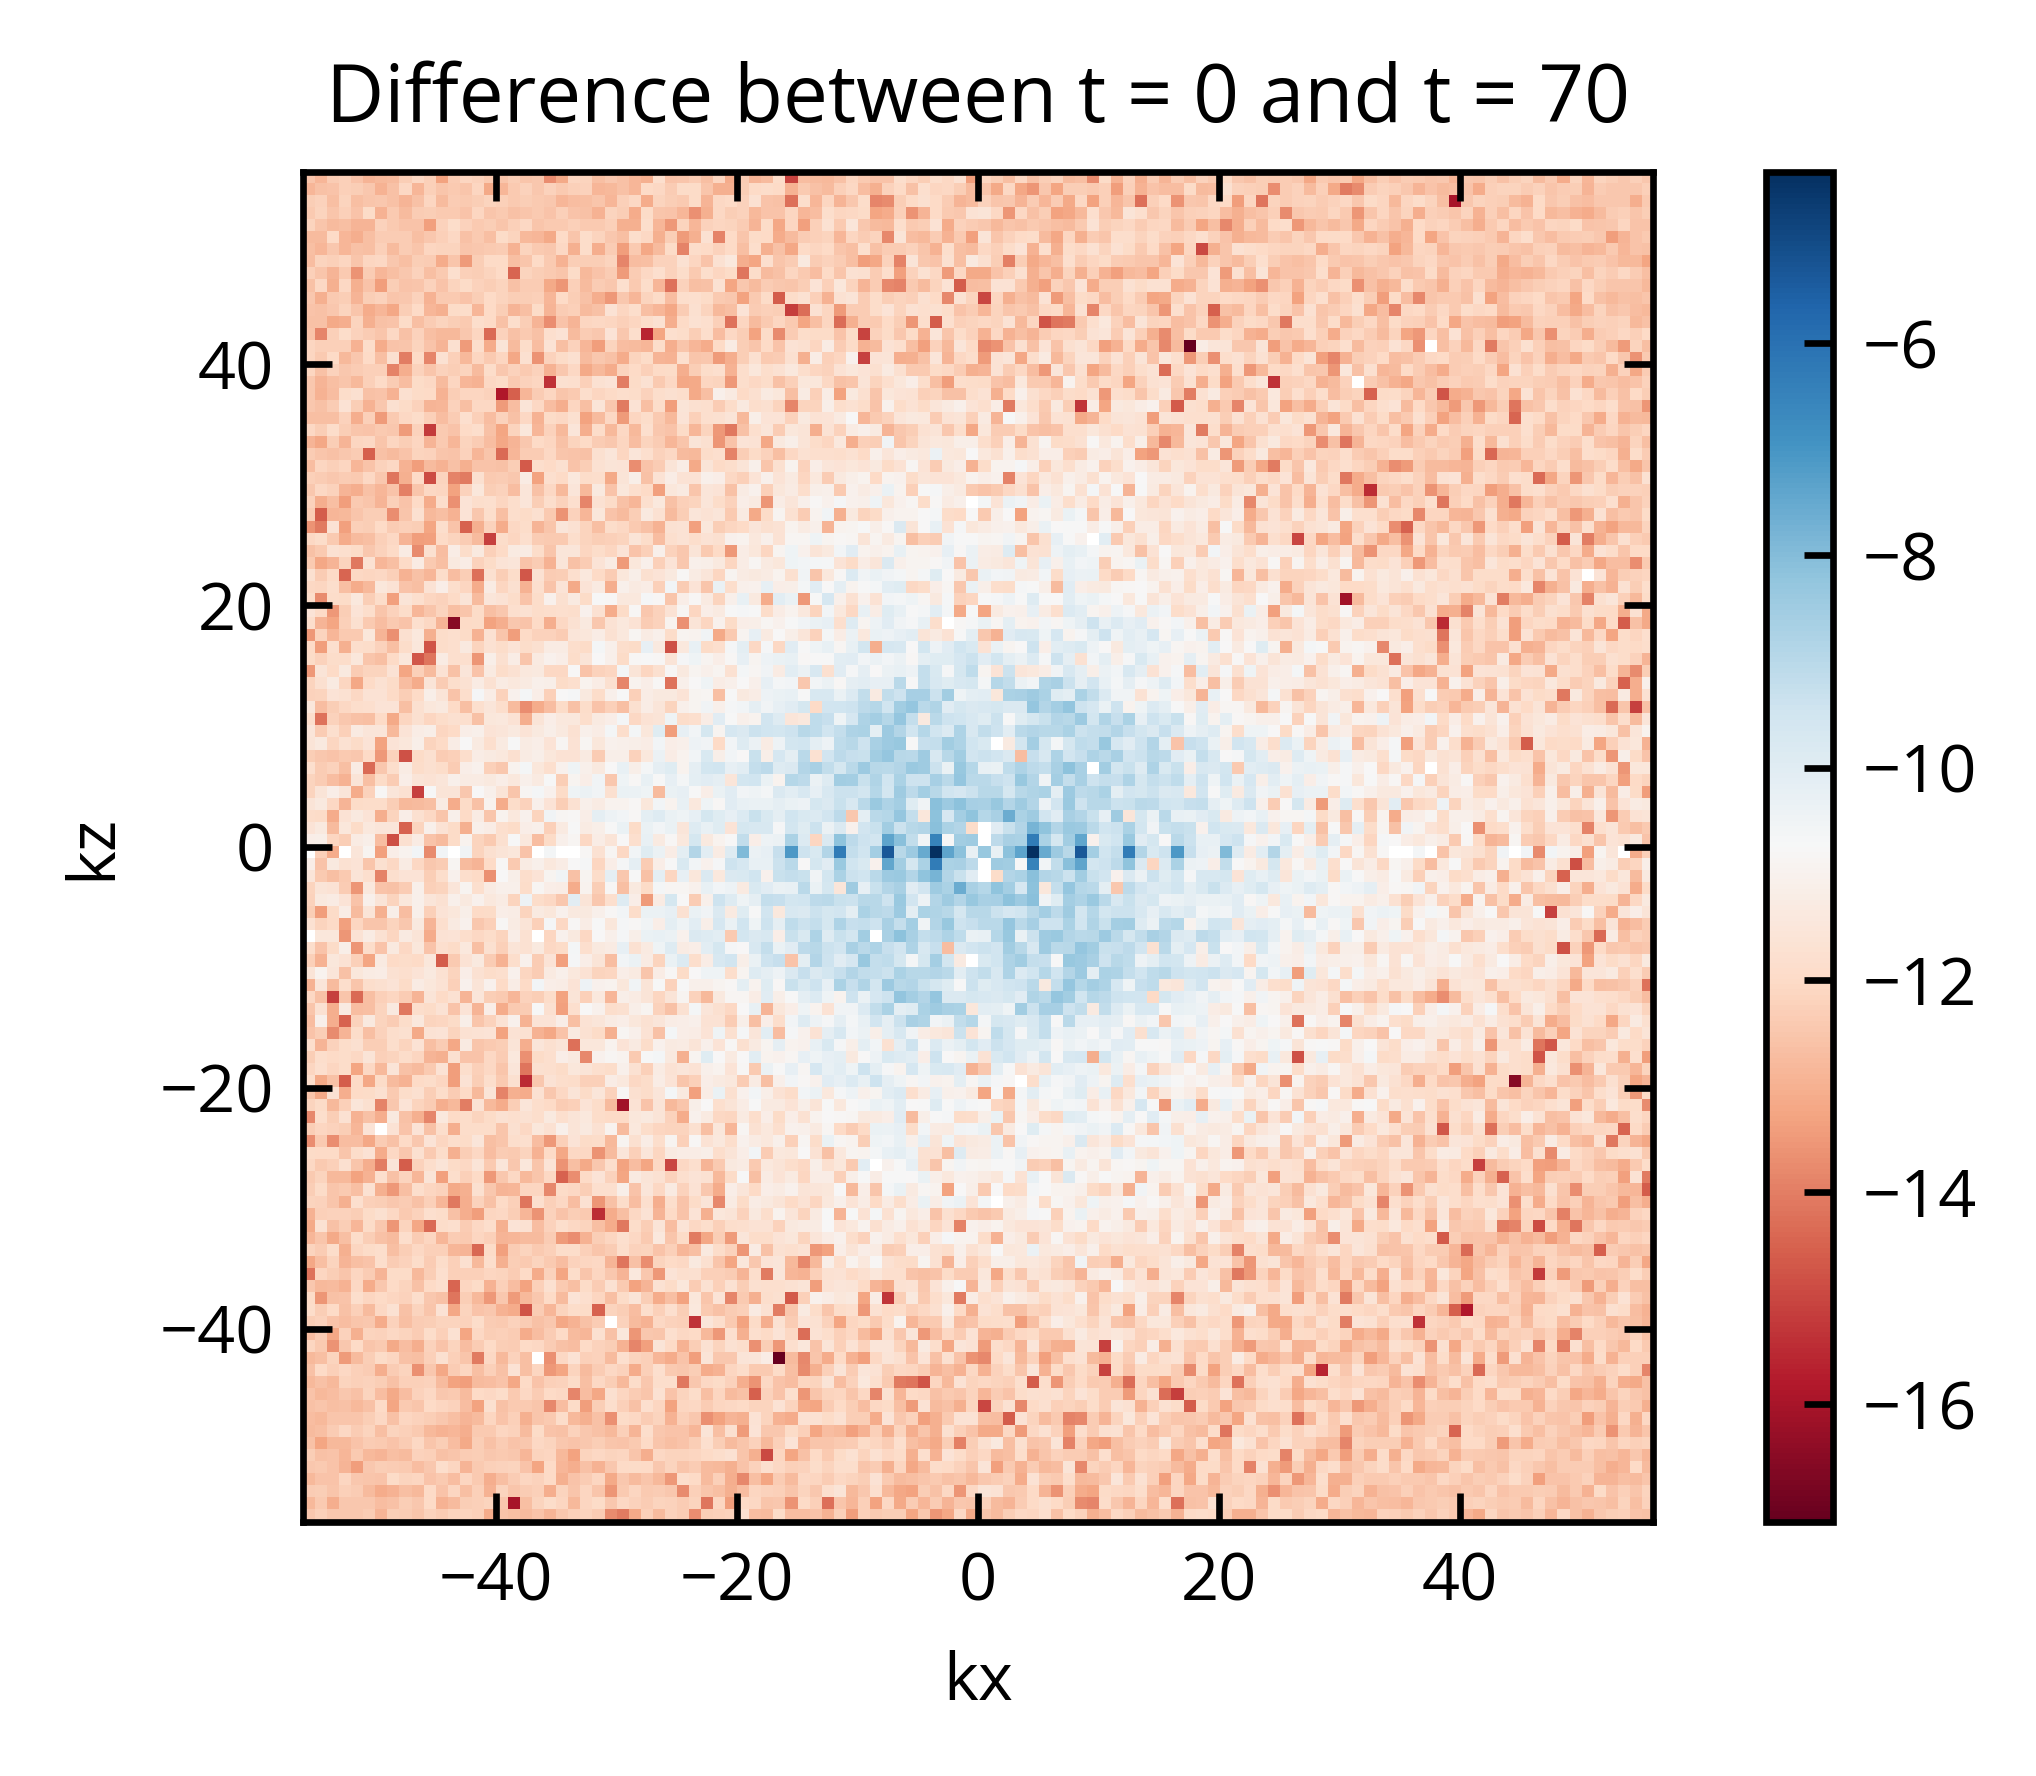

In [192]:
plt.figure(figsize=[4,3])

time = 0
eta_tile = case4.interface_t[time].eta_tile-1
N = 512; L = 2*np.pi
spectrum = np.fft.fft2(eta_tile)*(1/N)**2 # How to normalize here?!
F = np.absolute(spectrum)
F_center1 = np.fft.fftshift(F)

time = 35
eta_tile = case4.interface_t[time].eta_tile-1
N = 512; L = 2*np.pi
spectrum = np.fft.fft2(eta_tile)*(1/N)**2 # How to normalize here?!
F = np.absolute(spectrum)
F_center2 = np.fft.fftshift(F)

wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
kx = np.fft.fftshift(wavenumber)
ky = kx

plt.imshow(np.log(F_center2[200:-200,200:-200] - F_center1[200:-200,200:-200]), 
           extent = [kx[200],kx[-200],ky[200],ky[-200]], cmap='RdBu')
plt.xlabel('kx'); plt.ylabel('kz'); plt.colorbar(); 

plt.title('Difference between t = 0 and t = 70')
# plt.title('t = %g' %(time*2))

In [4]:
from scipy.interpolate import griddata
from scipy.signal import hilbert

from scipy.signal import butter,filtfilt
# Filter requirements.    
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx                  represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

class Snapchat:
    '''
    Class for every snapchat
    self.availt: The longest running time
    self.path: Path of the case file
    
    '''  
    def __init__(self, t, working_dir, NSLICE=256, NGRID=256, L0=np.pi*2):
        '''
        self.eta_raw: raw x,z,eta data
        self.eta_tile,self.x_tile,self.z_tile: interpolated eta,x,z with resolution specified by NGRID
        self.eta_1D: eta averaged over z direction
        '''
        self.t = t
        # Declare the fields
        self.ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        self.uy_3D = {'name':'uy', 'value':[]}
        # Read in the fields
        for field in (self.ux_3D,self.uy_3D):
            for sn in range (0,NSLICE-1):
                filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (self.t,sn)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                field['value'].append(snapshot[:,0:NGRID].astype(np.float))
            field['value'] = np.array(field['value'])
        # Read in eta
        filename = working_dir + 'eta/eta_t%g' % self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        self.eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
        # Interpolate over x-z plane with the same resolutions
        xarray = np.linspace(-L0/2,L0/2,NGRID); zarray = np.linspace(-L0/2,L0/2,NGRID)
        self.x_tile, self.z_tile = np.meshgrid(xarray,zarray)
        self.eta_tile = griddata((self.eta_raw['x'].ravel(), self.eta_raw['z'].ravel()), self.eta_raw['eta'].ravel(), 
                                 (self.x_tile, self.z_tile), method='nearest')
        # Hilbert transform, performed along x
        # !To-dos: test for non quasi 1D cases
        self.eta_1D = np.average(self.eta_tile, axis=0)
        # Filter the data (subtract the mean)
        self.eta_1D_filtered = butter_lowpass_filter(self.eta_1D-np.average(self.eta_1D))
        analytic_signal = hilbert(self.eta_1D_filtered)
        self.phase = np.angle(analytic_signal)
        # Shift the velocity field along x axis so that phase starts at 0
        self.idx = (np.abs(self.phase - 0)).argmin()
        self.eta_1D_shift = np.roll(self.eta_1D, -self.idx)
        self.ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        self.uy_3D_shift = {'name':'uy_shift', 'value':[]}
        for (field,field_shift) in zip((self.ux_3D,self.uy_3D),(self.ux_3D_shift,self.uy_3D_shift)):
            field_shift['value'] = np.roll(field['value'], -self.idx, axis=1)

In [ ]:
dirname = case9.path
snapchat_ensemble = []
for i in range(0,11):
    t = 71 + i
    snapchat = Snapchat(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)
    snapchat_ensemble.append(snapchat)

In [5]:
# Pick a case, and time range
case = case9
time = np.arange(71,81,1)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
working_dir = case.path
eta =[]; eta_shift = []
ux = []; uy = []
ux_shift = []; uy_shift = []
re_stress_shift  = []
for t in tqdm(time):
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
    # Interpolate over x-z plane with the same resolutions
    xarray = np.linspace(-L0/2,L0/2,NGRID); zarray = np.linspace(-L0/2,L0/2,NGRID)
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)
    # Filter the data (subtract the mean)
    eta_1D_filtered = butter_lowpass_filter(eta_1D-np.average(eta_1D))
    analytic_signal = hilbert(eta_1D_filtered)
    phase = np.angle(analytic_signal)
    # Shift the velocity field along x axis so that phase starts at 0
    idx = (np.abs(phase - 0)).argmin()
    eta_1D_shift = np.roll(eta_1D, -idx)
    ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
    uy_3D = {'name':'uy', 'value':[]}
    # Read in the fields
    for field in (ux_3D,uy_3D):
        for sn in range (0, NSLICE-1):
            filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,sn)
            snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
            snapshot.reshape([NGRID,NGRID+1])
            field['value'].append(snapshot[:,0:NGRID].astype(np.float))
        field['value'] = np.array(field['value'])
    ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
    uy_3D_shift = {'name':'uy_shift', 'value':[]}
    for (field,field_shift) in zip((ux_3D,uy_3D),(ux_3D_shift,uy_3D_shift)):
        field_shift['value'] = np.roll(field['value'], -idx, axis=1)
    # Compute Reynolds stress
    ux_mean = np.tile(np.average(ux_3D_shift['value'], axis=(0,1)), (ux_3D_shift['value'].shape[1], 1))
    uy_mean = np.tile(np.average(uy_3D_shift['value'], axis=(0,1)), (uy_3D_shift['value'].shape[1], 1))
    re_stress_3D = (ux_3D_shift['value']-ux_mean)*(uy_3D_shift['value']-uy_mean)
    # Append z direction averaged 2D profile
    re_stress_shift.append(np.average(re_stress_3D, axis=0))
    eta.append(eta_1D); eta_shift.append(eta_1D_shift)
    ux.append(np.average(ux_3D['value'], axis=0)); uy.append(np.average(uy_3D['value'],axis=0))
    ux_shift.append(np.average(ux_3D_shift['value'], axis=0)); uy_shift.append(np.average(uy_3D_shift['value'],axis=0))

  0%|          | 0/10 [00:00<?, ?it/s]/home/jiarong/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
100%|██████████| 10/10 [14:47<00:00, 89.33s/it]


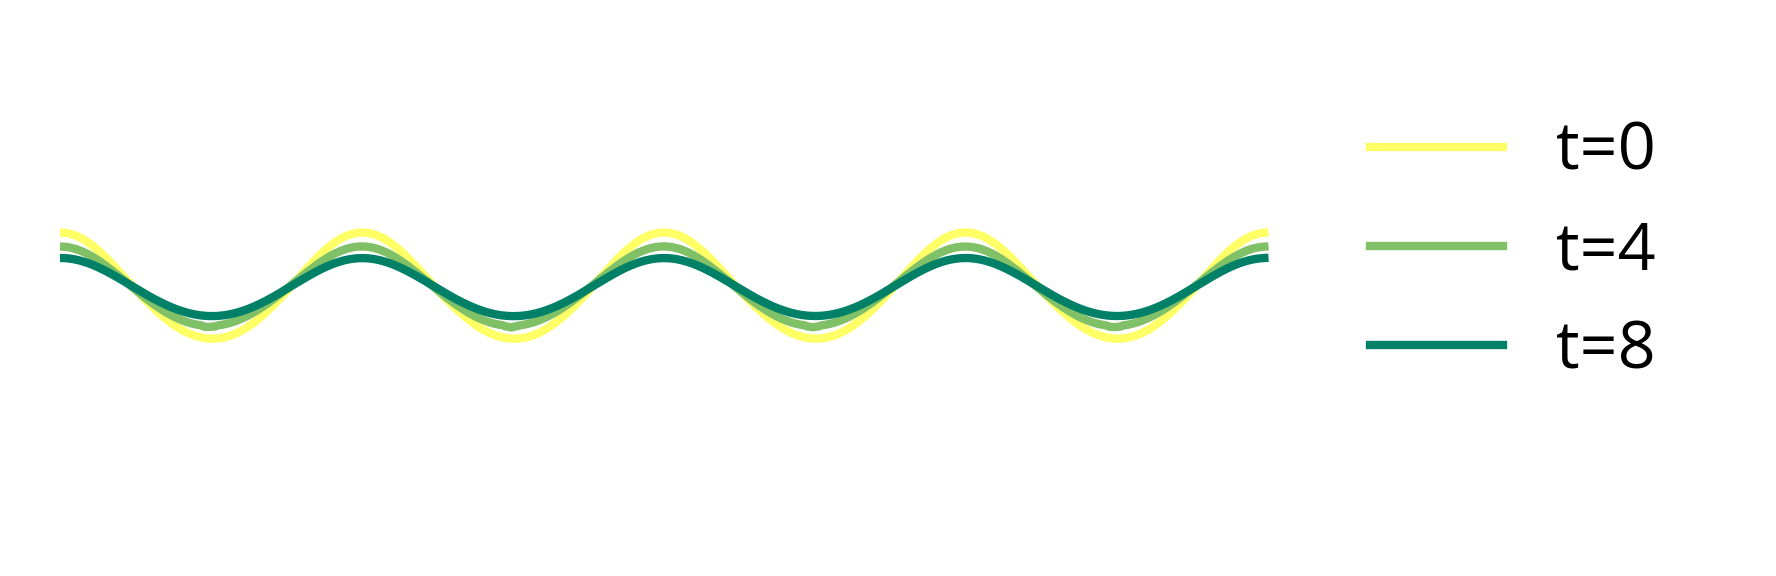

In [44]:
x = np.linspace(-2,2,512)
plt.figure(figsize = [3,1])
for i in range(0,11,4):
    plt.plot(x, eta_shift[i+1]-1, color=plt.cm.get_cmap('summer')(1-i/8), label='t=%g' %i, lw=1)
plt.ylim([-0.1,0.1]); plt.xlim([-2,3.5]); plt.xlabel('$x/\lambda$')
plt.axis('off'); plt.legend()

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


(-3.141592653589793, 3.141592653589793, 0.0, 1.5707963267948966)

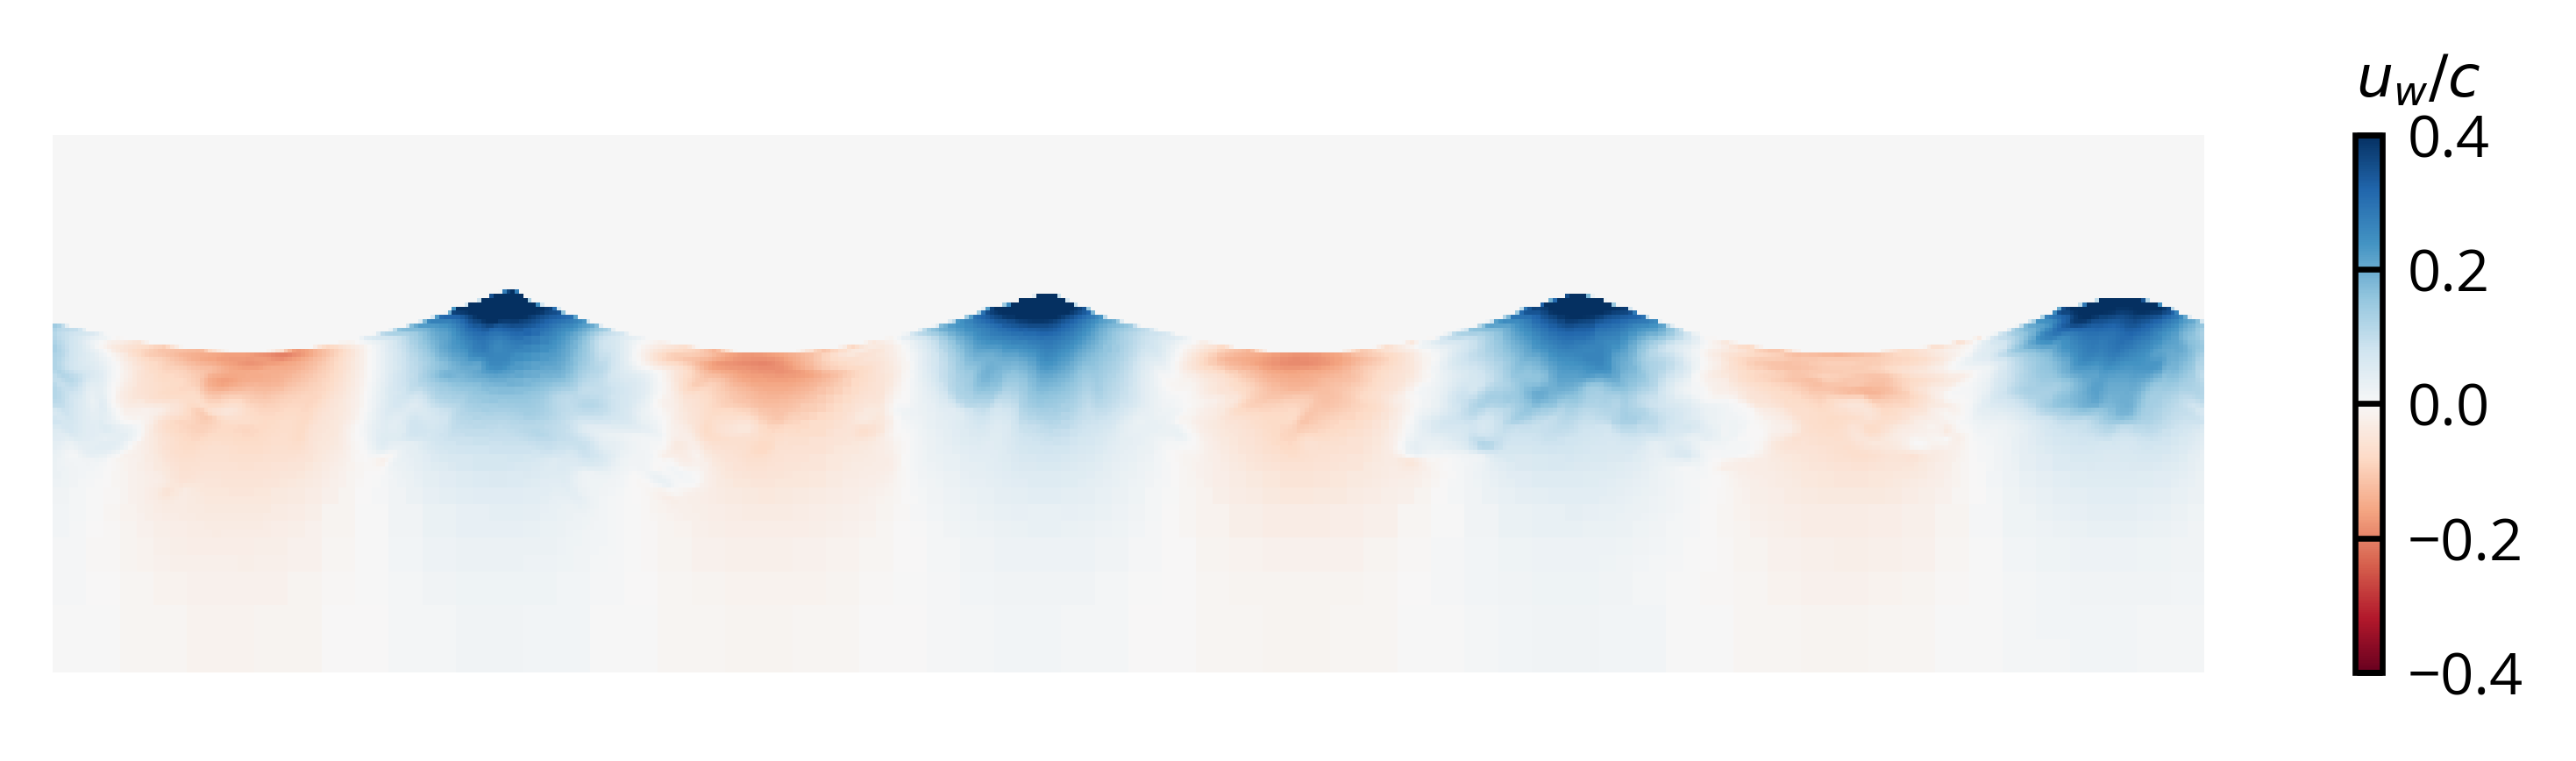

In [193]:
""" See if there is turbulence in the water. x-y slice """
fig = plt.figure (figsize = [6,1.5])
case = case4
time = np.arange(124,125,1)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
nslice = 90 # number of chosen slice 
working_dir = case.path

for t in tqdm(time):
    filename = working_dir + 'field/' + 'f' + '_t%g_slice%g' % (t,nslice)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    f = np.array(snapshot[:,0:NGRID].astype(np.float))
    filename = working_dir + 'field/' + 'ux' + '_t%g_slice%g' % (t,nslice)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    ux = np.array(snapshot[:,0:NGRID].astype(np.float))
    u_water = f*ux
plt.imshow(np.rot90(u_water[:,0:128])/case.wave.c, cmap='RdBu', vmax = 0.4, vmin = -0.4, extent=[-np.pi,np.pi,0,0.5*np.pi])
ax = plt.gca(); ax.text(1.1,1.1, r'$u_w/c$', ha='center', va='center', transform=ax.transAxes)
plt.colorbar(); ax.axis('off')

100%|██████████| 1/1 [01:19<00:00, 79.81s/it]


(-3.141592653589793, 3.141592653589793, 0.0, 1.5707963267948966)

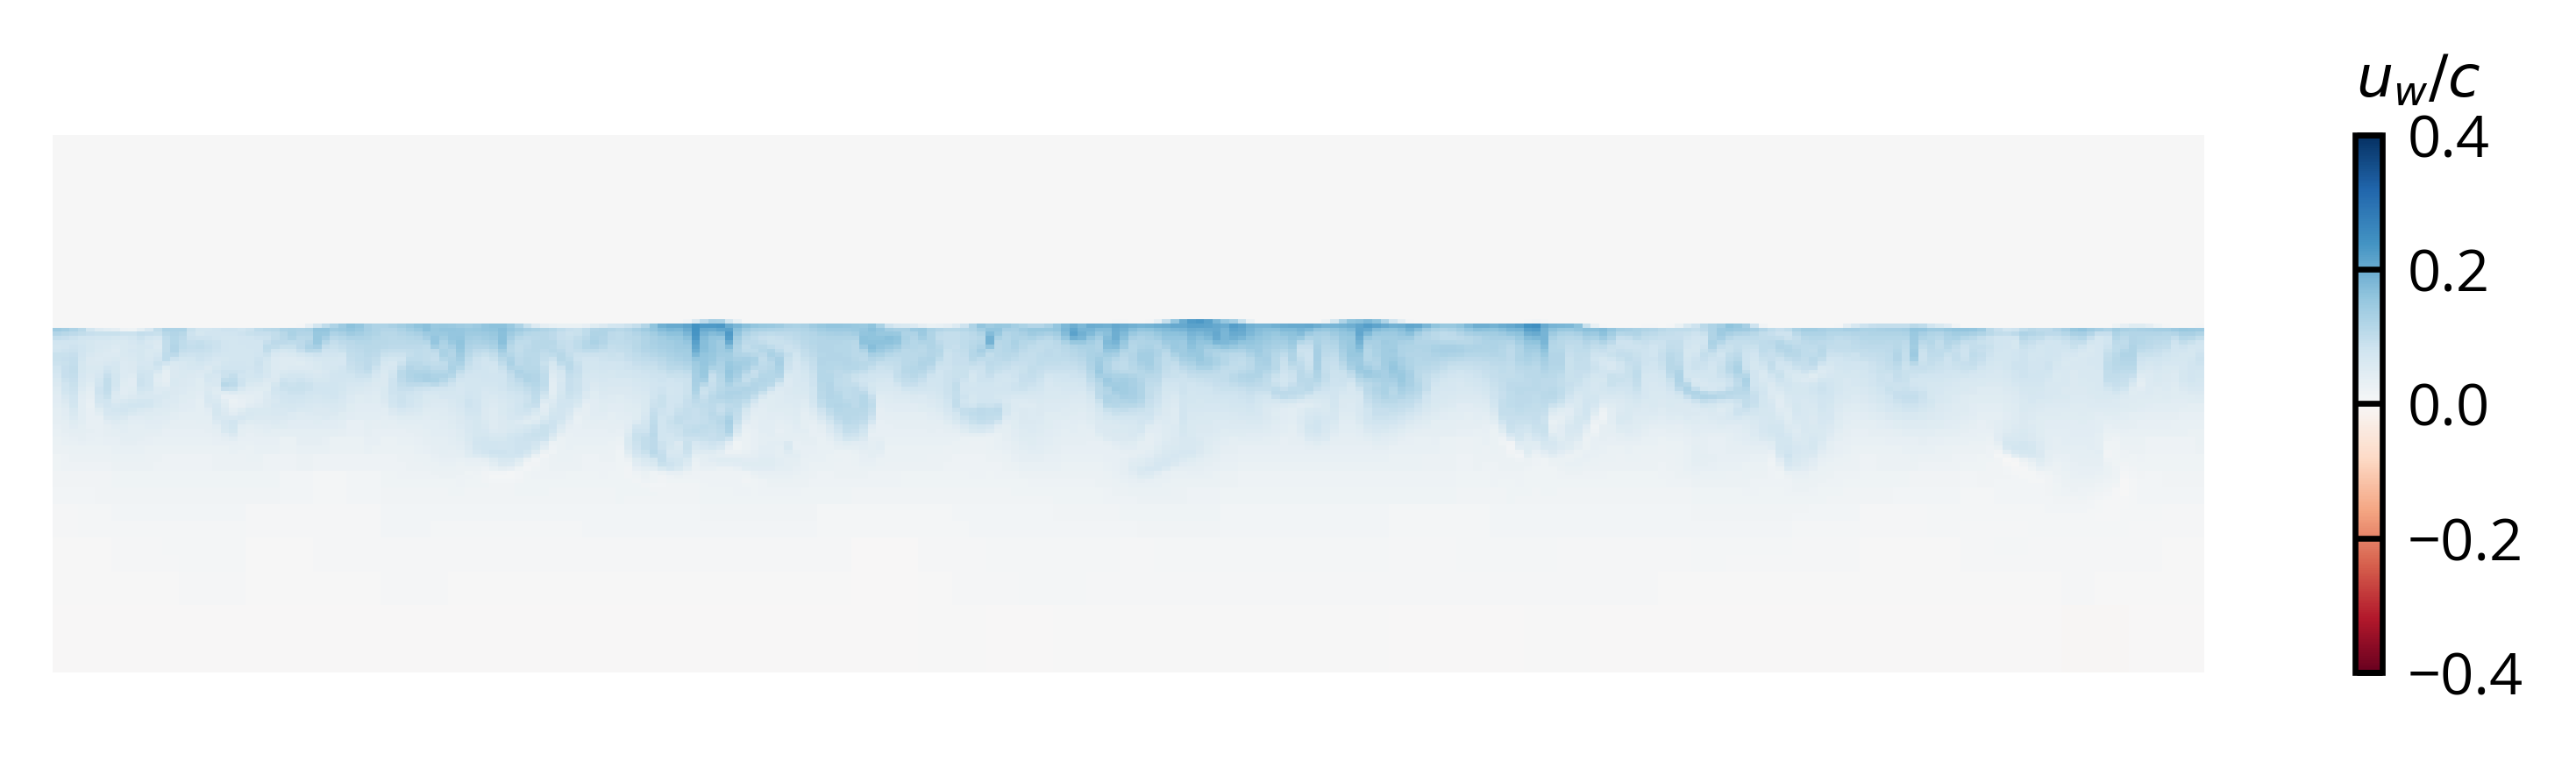

In [195]:
""" See if there is turbulence in the water. x-z slice """
fig = plt.figure (figsize = [6,1.5])
case = case4
time = np.arange(124,125,1)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
working_dir = case.path

ux3D = []
for t in tqdm(time):
    for nslice in range(0,256):
        filename = working_dir + 'field/' + 'f' + '_t%g_slice%g' % (t,nslice)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        f = np.array(snapshot[:,0:NGRID].astype(np.float))
        filename = working_dir + 'field/' + 'ux' + '_t%g_slice%g' % (t,nslice)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        ux = np.array(snapshot[:,0:NGRID].astype(np.float))
        u_water = f*ux
        # axis0-z; axis1-x; axis2-y
        ux3D.append(u_water)
ux3D = np.array(ux3D)

# Choose a slice 
plt.imshow(np.rot90(ux3D[:,256,0:128])/case.wave.c, cmap='RdBu', vmax = 0.4, vmin = -0.4, extent=[-np.pi,np.pi,0,0.5*np.pi])
ax = plt.gca(); ax.text(1.1,1.1, r'$u_w/c$', ha='center', va='center', transform=ax.transAxes)
plt.colorbar(); ax.axis('off')

In [ ]:
""" Pre-process for the eta: interpolate it onto uniform grid (with nearest method). """
filename = 'case1_re_stress'
outfile = open(filename,'wb')
pickle.dump(re_stress,outfile)
outfile.close()


In [ ]:
""" Fourier transform and spectrogram of the interface. """

In [225]:
filename = 'case1_re_stress'
outfile = open(filename,'wb')
pickle.dump(re_stress,outfile)
outfile.close()

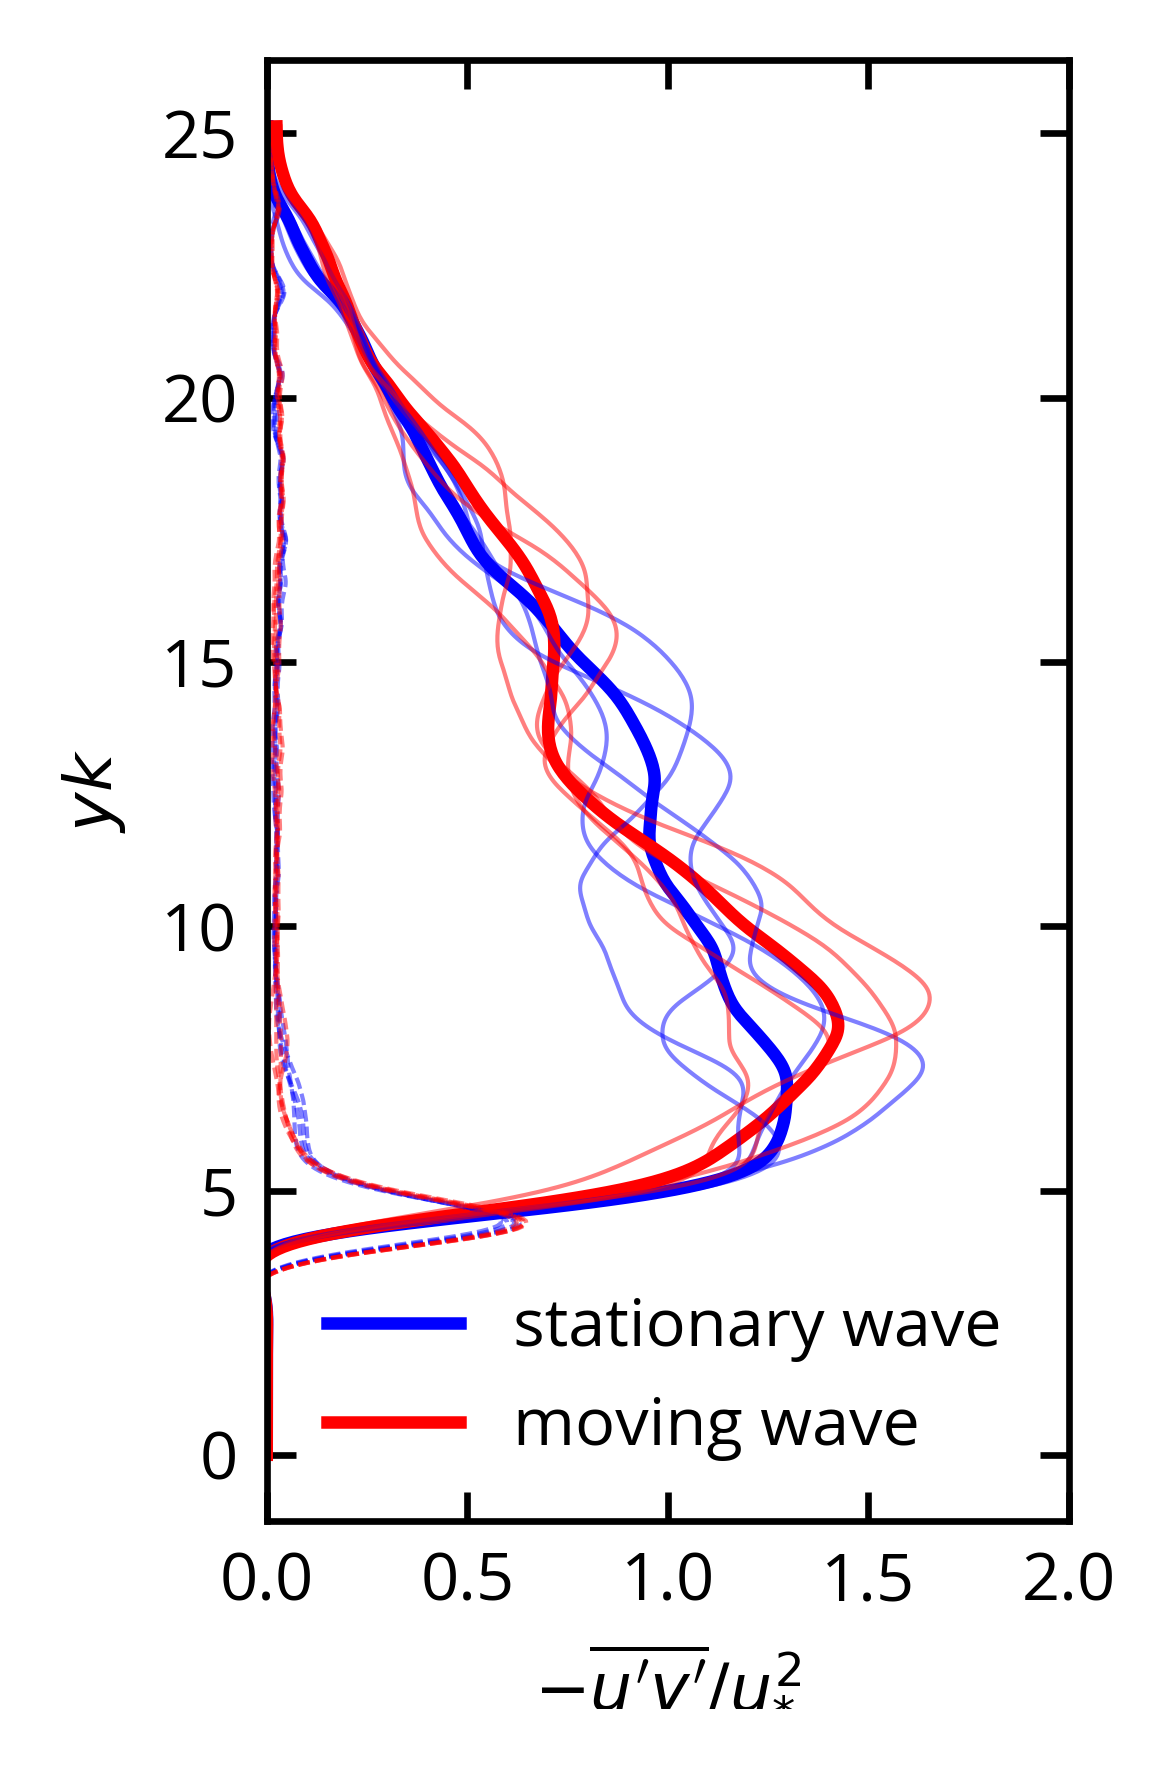

In [13]:
'''Plotting Reynolds stress (averaged)'''
plt.figure(figsize=(2,3))
case = case9
# case.mean_profile([250])
case.yarray = np.linspace(0,2*np.pi,512)
re_stress_ensemble_aver = np.average(re_stress_shift[0:4], axis=(0,1))
re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
plt.plot(-re_stress_ensemble_aver/0.25**2, case.yarray*case.k, c='blue', label='stationary wave')
re_stress_ensemble_aver = np.average(re_stress_shift[6:10], axis=(0,1))
re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
plt.plot(-re_stress_ensemble_aver/0.25**2, case.yarray*case.k, c='red', label='moving wave')
for i in range(0,4):
    re_stress = butter_lowpass_filter(-np.average(re_stress_shift[i],axis=0))
    plt.plot(re_stress/0.25**2, case.yarray*case.k, c='blue', alpha=0.5, lw=0.5)
    ux_ensemble_aver = np.average(ux_shift[i], axis=0)
    ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
    plt.plot(np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2/0.25**2, case.yarray*case.k,
             '--', c='blue', alpha=0.5, lw=0.5)
#     plt.plot((np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2+re_stress)/0.25**2, case.yarray*case.k,
#              '--', c='blue', alpha=0.5, lw=0.5)
for i in range(6,10):
    re_stress = butter_lowpass_filter(-np.average(re_stress_shift[i],axis=0))
    plt.plot(re_stress/0.25**2, case.yarray*case.k, c='red', alpha=0.5, lw=0.5)
    ux_ensemble_aver = np.average(ux_shift[i], axis=0)
    ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
    plt.plot(np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2/0.25**2, case.yarray*case.k,
             '--', c='red', alpha=0.5, lw=0.5)
# plt.plot(-re_stress_ensemble_aver/0.25**2, case.yarray*case.k)
# ux_ensemble_aver = np.average(ux_shift, axis=(0,1))
# ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
# plt.plot(np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2/0.25**2, case.yarray*case.k,
#        label = '\tau_\nu')
plt.ylabel(r'$yk$'); plt.xlabel(r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^{2}$')
plt.xlim([0,2])
plt.legend()

Text(-1.3, 0, '$-\\overline{u^{\\prime} v^{\\prime}}/u_{*}^{2}$')

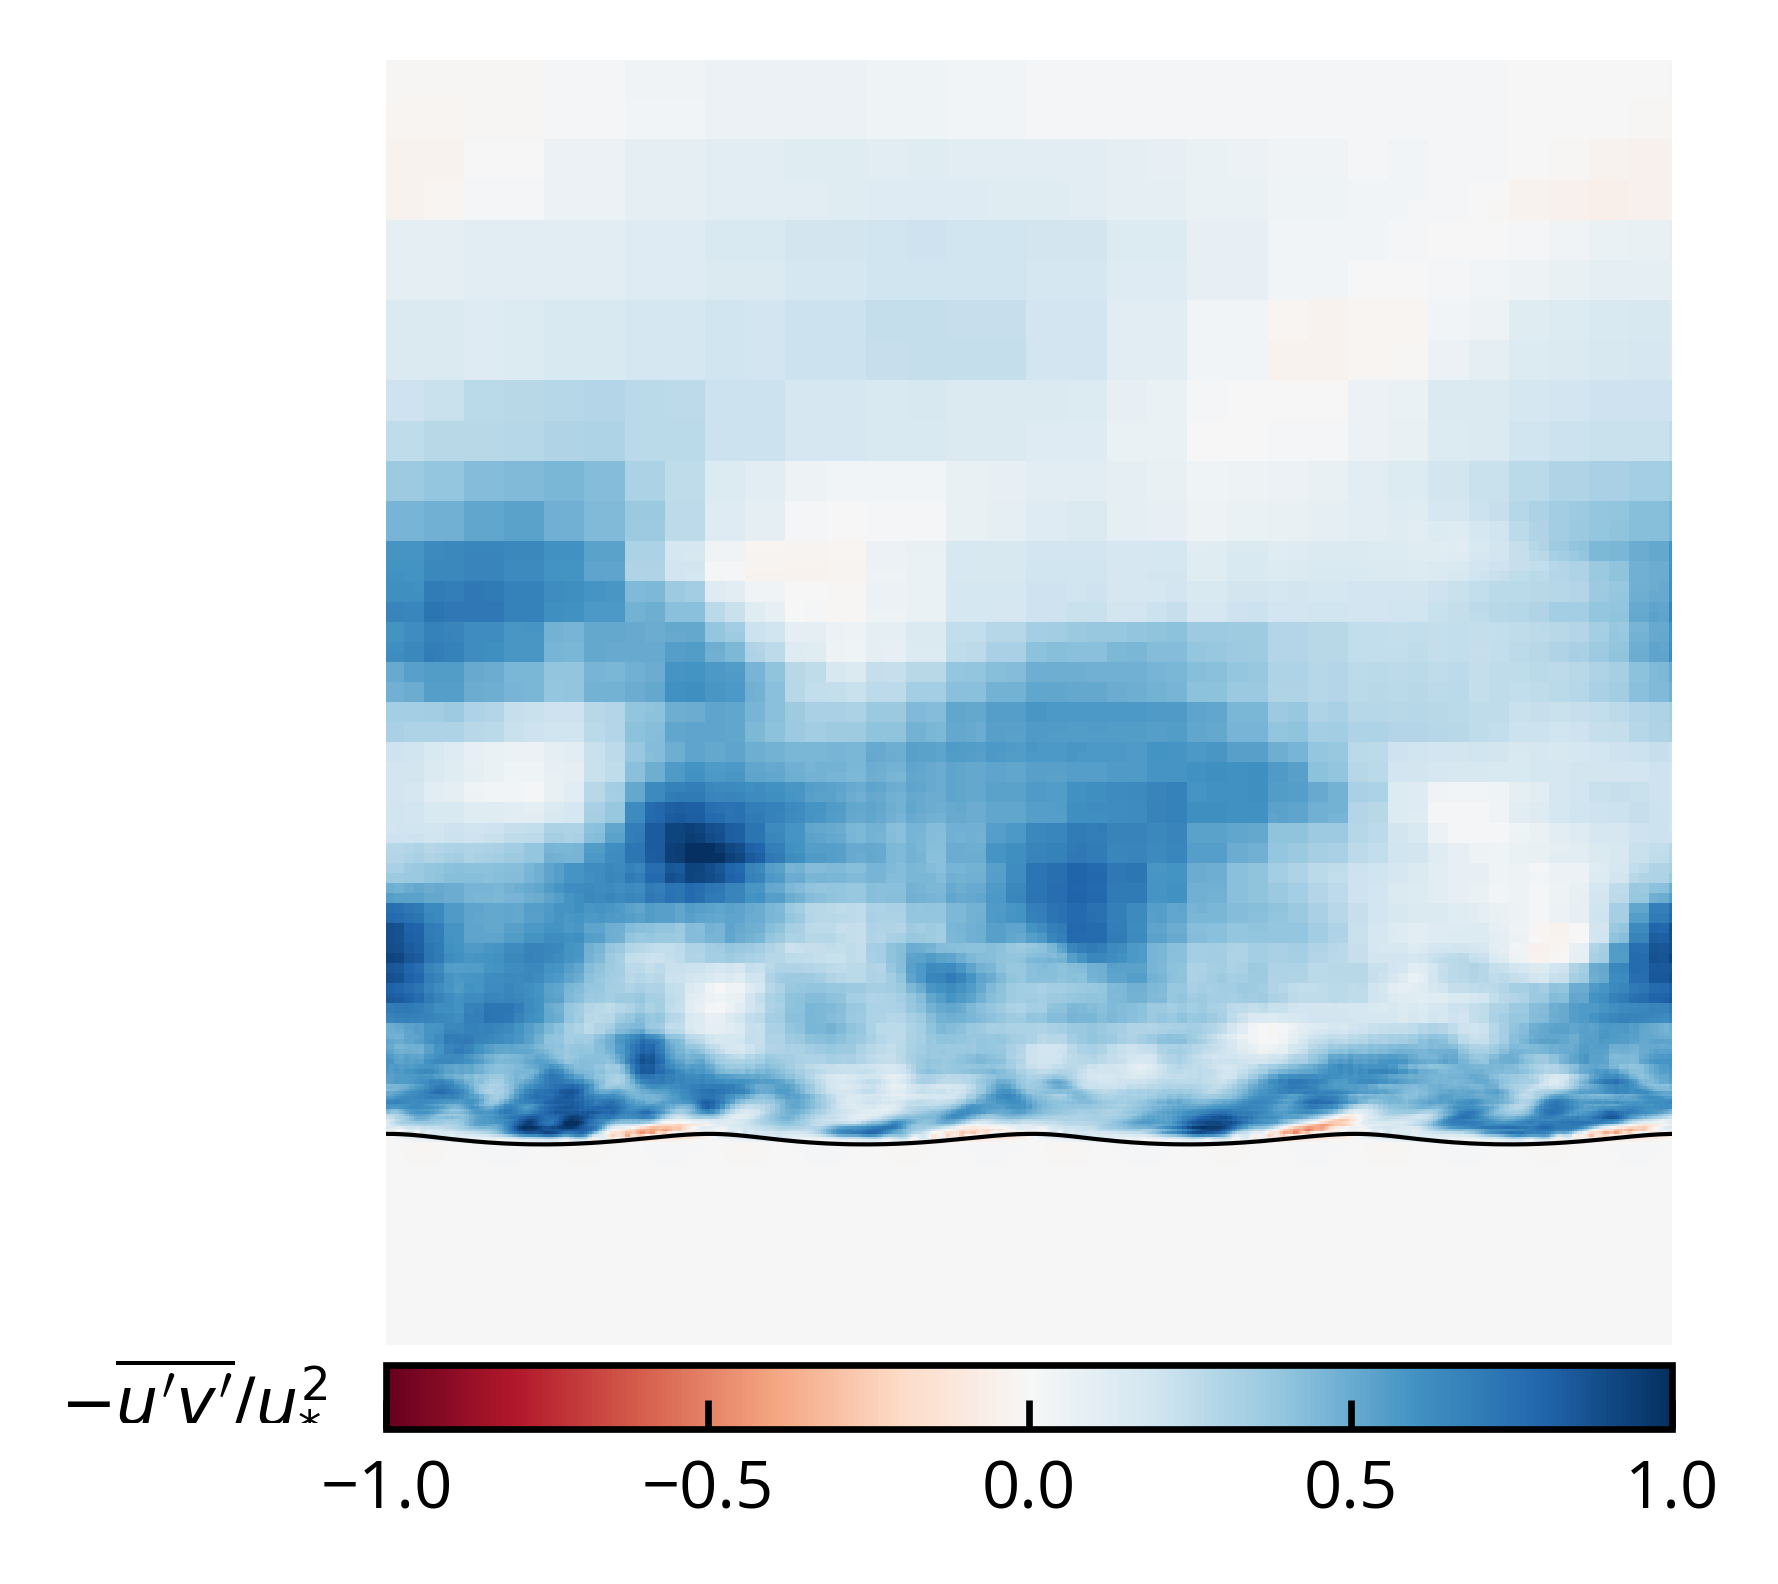

In [107]:
'''Plotting Reynolds stress'''
x = np.average(x_tile,axis=0)
fig = plt.figure(figsize=(3,3.5))
img = plt.imshow(np.rot90(-np.average(re_stress_shift, axis=0)/0.25**2),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi], vmax=1,vmin=-1)
# img = plt.imshow(np.rot90(uy_shift[0]/0.25),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=0.6,vmin=-0.6)
plt.plot(x,eta_1D_shift,color='k',lw=0.5)
plt.axis('off')
cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
cbar.ax.text(-1.3, 0, r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^{2}$', ha='center', va='center')

Text(-0.7, 0, '$v/u_*$')

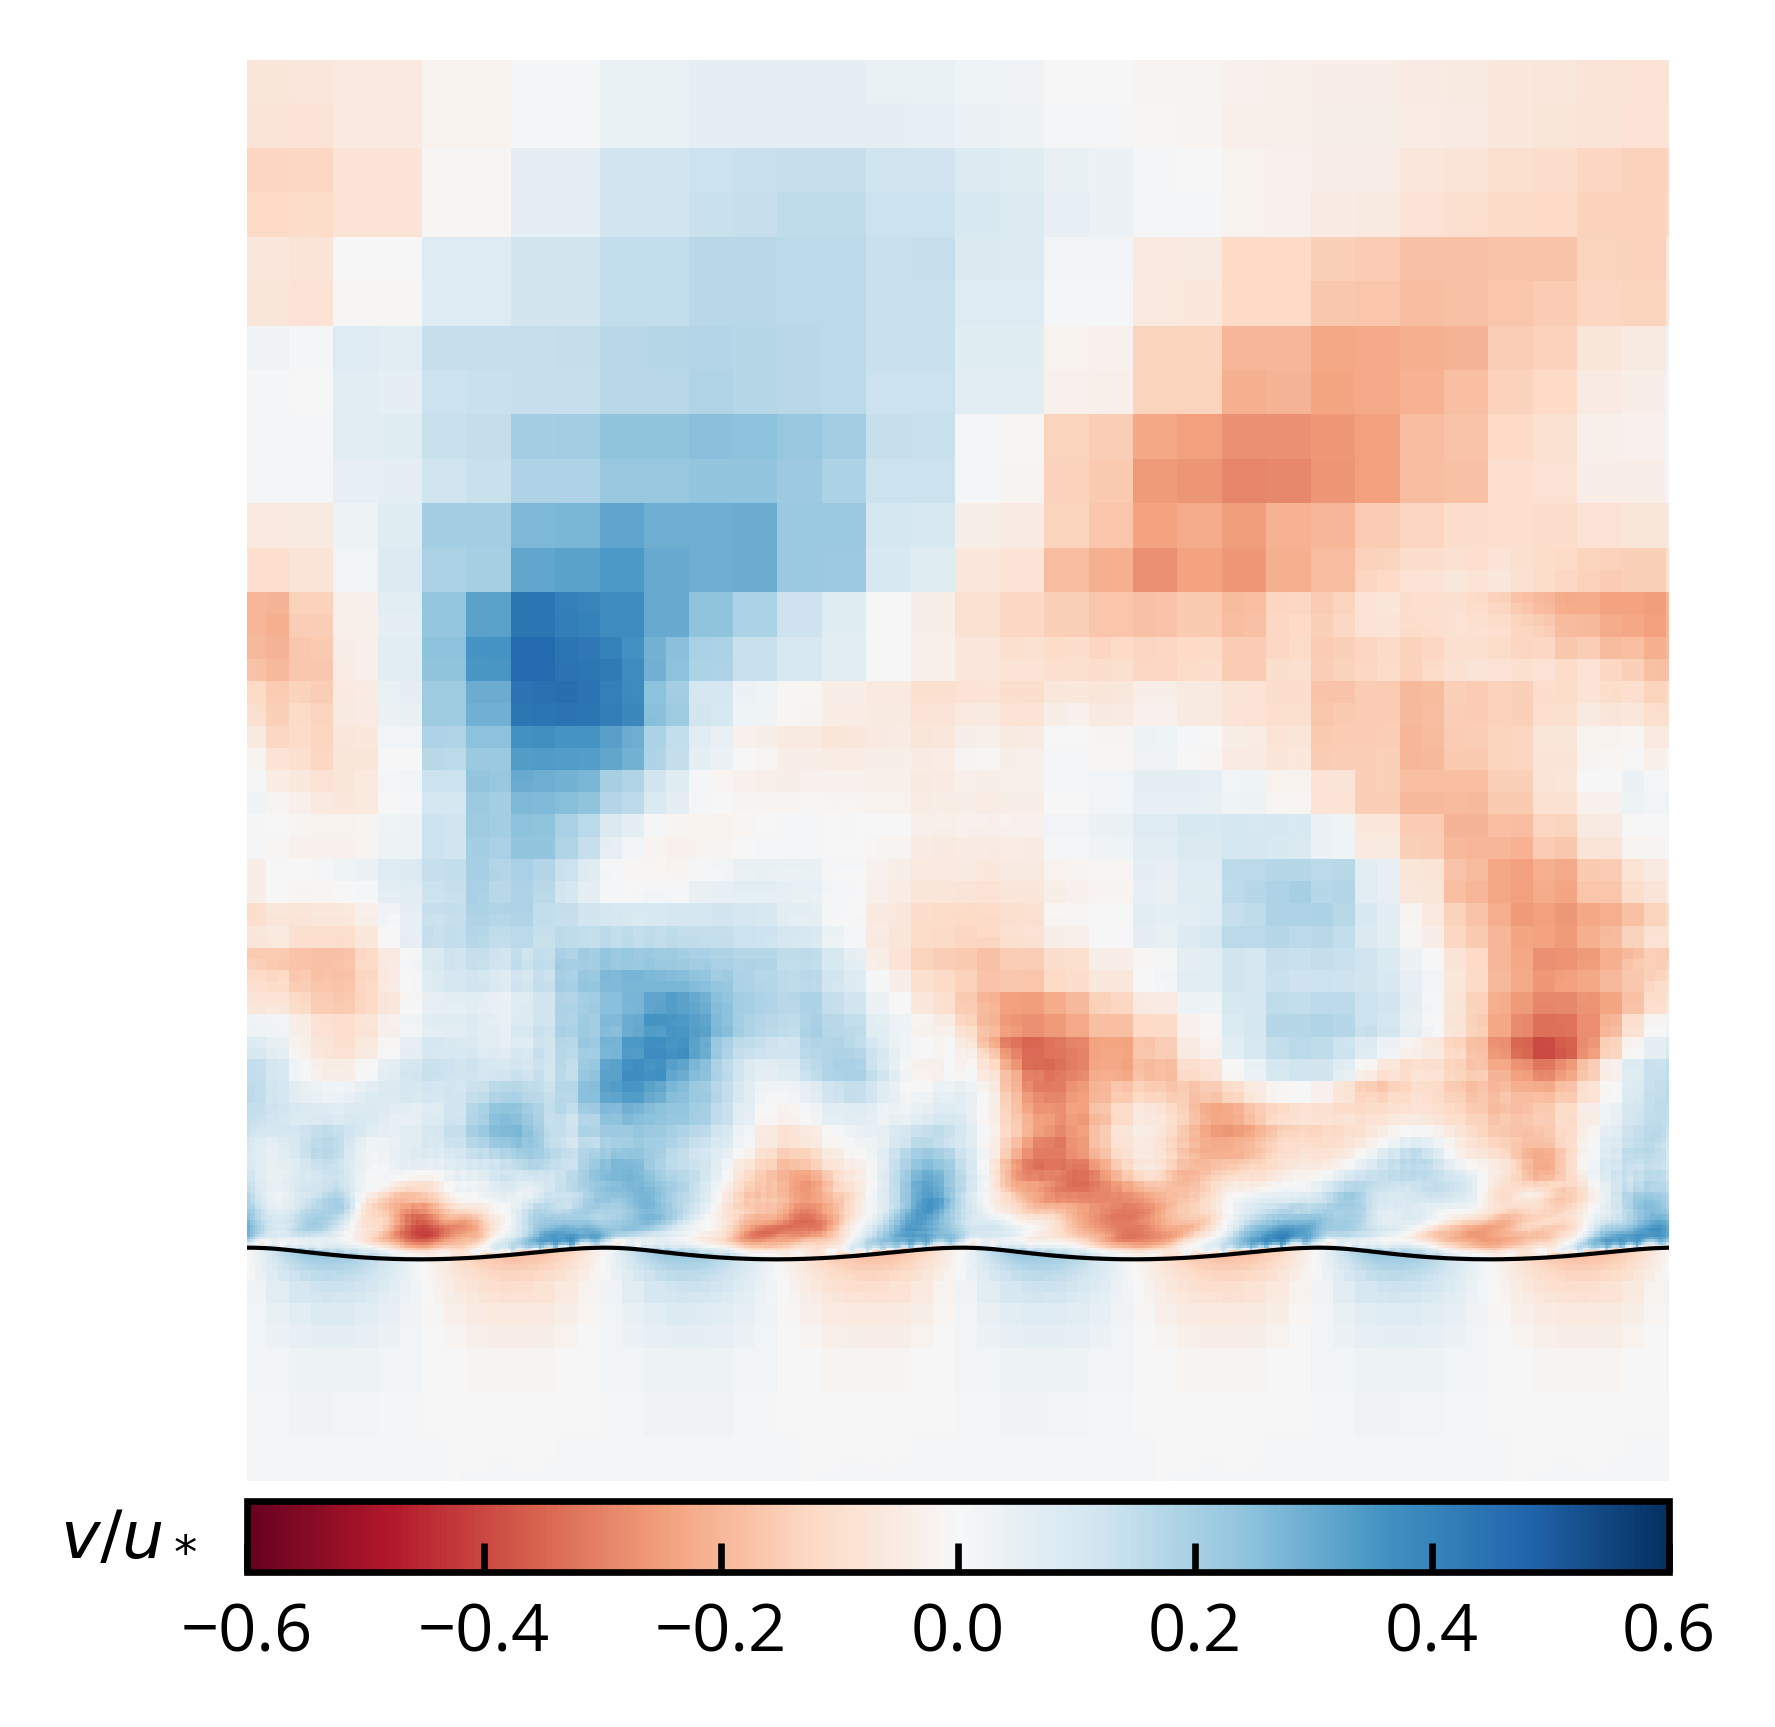

In [75]:
'''Plotting v'''
x = np.average(x_tile,axis=0)
fig = plt.figure(figsize=(3,3.5))
img = plt.imshow(np.rot90(np.average(uy_shift, axis=0)/0.25),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=0.6,vmin=-0.6)
# img = plt.imshow(np.rot90(uy_shift[0]/0.25),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=0.6,vmin=-0.6)
plt.plot(x,eta_1D_shift,color='k',lw=0.5)
plt.axis('off')
cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
cbar.ax.text(-0.7, 0, r'$v/u_*$', ha='center', va='center')

In [ ]:
# Wave field visualization

In [ ]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

plt.rcParams['figure.dpi'] = 600

case = case2
time = np.arange(203,204)
NGRID = 512; NSLICE = 256; L0 = 2*np.pi
working_dir = case.path

# Read in only the center slice
def read_center(t):
    filename = working_dir + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
    # Interpolate over x-z plane with the same resolutions
    xarray = np.linspace(-L0/2,L0/2,NGRID); zarray = np.linspace(-L0/2,L0/2,NGRID)
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_tile = griddata((eta_raw['x'].ravel(), eta_raw['z'].ravel()), eta_raw['eta'].ravel(), 
                             (x_tile, z_tile), method='nearest')
    eta_1D = np.average(eta_tile, axis=0)
    ux_2D = {'name':'ux', 'value':[]} # center slice in z, axis0 in x, axis1 in y  (in the code)
    uy_2D = {'name':'uy', 'value':[]}
    # Read in the fields
    for field in (ux_2D,uy_2D):
        filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (t,NSLICE/2)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        field['value'] = snapshot[:,0:NGRID].astype(np.float)
    return ux_2D, uy_2D, eta_1D

# Single animation generation function
def plot_animation(frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate  
    fig = plt.figure(figsize=(3,3.5))
    tstart = 203
    ux_2D,uy_2D,eta_1D = read_center(tstart)
    img = plt.imshow(np.rot90(uy_2D['value']/0.25),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=1.5,vmin=-1.5)
    x = np.linspace(-L0/2,L0/2,NGRID)
    plt.plot(x,eta_1D,color='k',lw=0.5)
    plt.axis('off'); plt.title('t = %g' %tstart)
    cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
    cbar.ax.text(-1.8, 0, r'$v/u_*$', ha='center', va='center')

    # animation function.  This is called sequentially
    def animate(i):
        fig.clear()
        ux_2D,uy_2D,eta_1D = read_center(i+tstart)
        img = plt.imshow(np.rot90(uy_2D['value']/0.25),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=1.5,vmin=-1.5)
        x = np.linspace(-L0/2,L0/2,NGRID)
        plt.plot(x,eta_1D,color='k',lw=0.5)
        plt.axis('off'); plt.title('t = %g' %(i+tstart))
        cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
        cbar.ax.text(-1.8, 0, r'$v/u_*$', ha='center', va='center')
        return img

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = False)  
    return anim

anim = plot_animation(frame_number = 6, interval_time = 400) # Specify frame number
HTML(anim.to_html5_video())

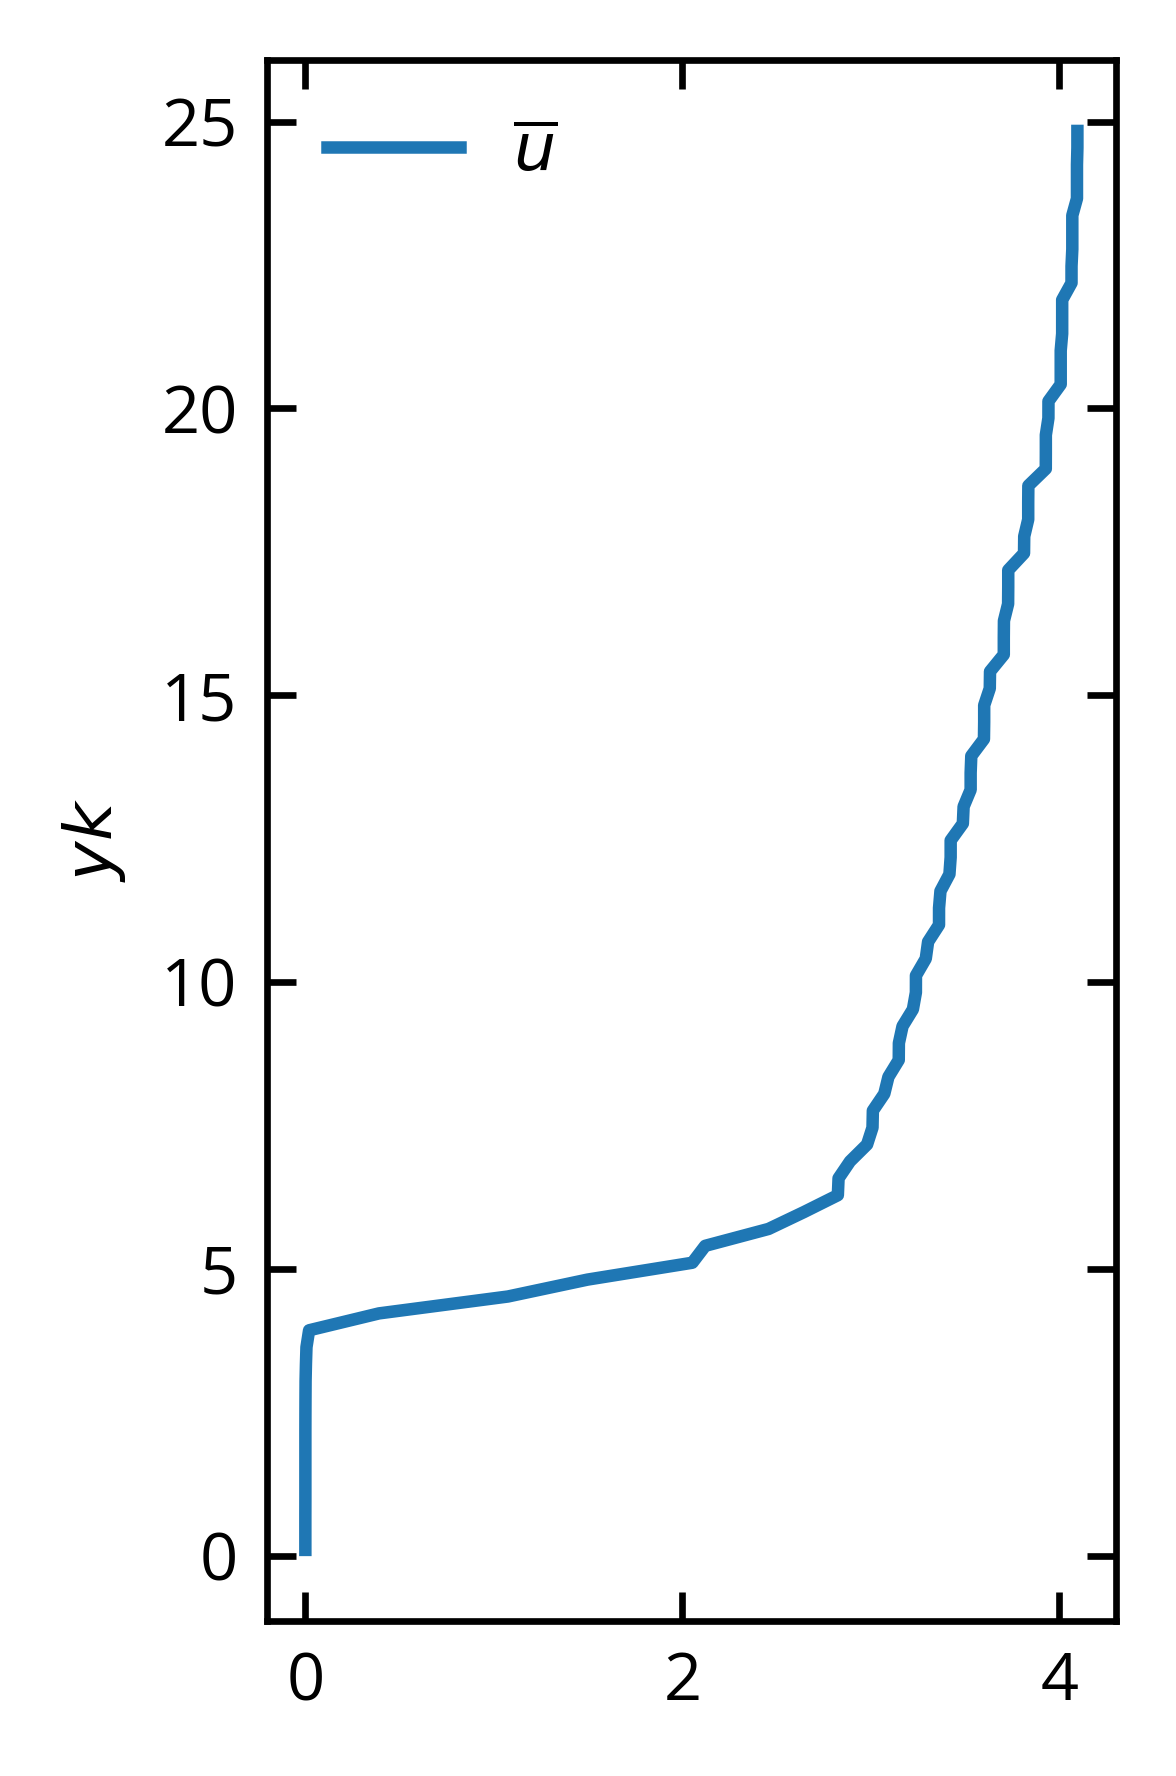

In [65]:
'''Plotting u (averaged)'''
case = case6
# case.mean_profile([253])
ux_ensemble_aver = np.average(ux_shift, axis=(0,1))
plt.figure(figsize=(2,3))
plt.plot(ux_ensemble_aver[1:-1:3], case.yarray[1:-1:3]*case.k, label=r'$\overline{u}$')
plt.ylabel(r'$yk$'); plt.legend()

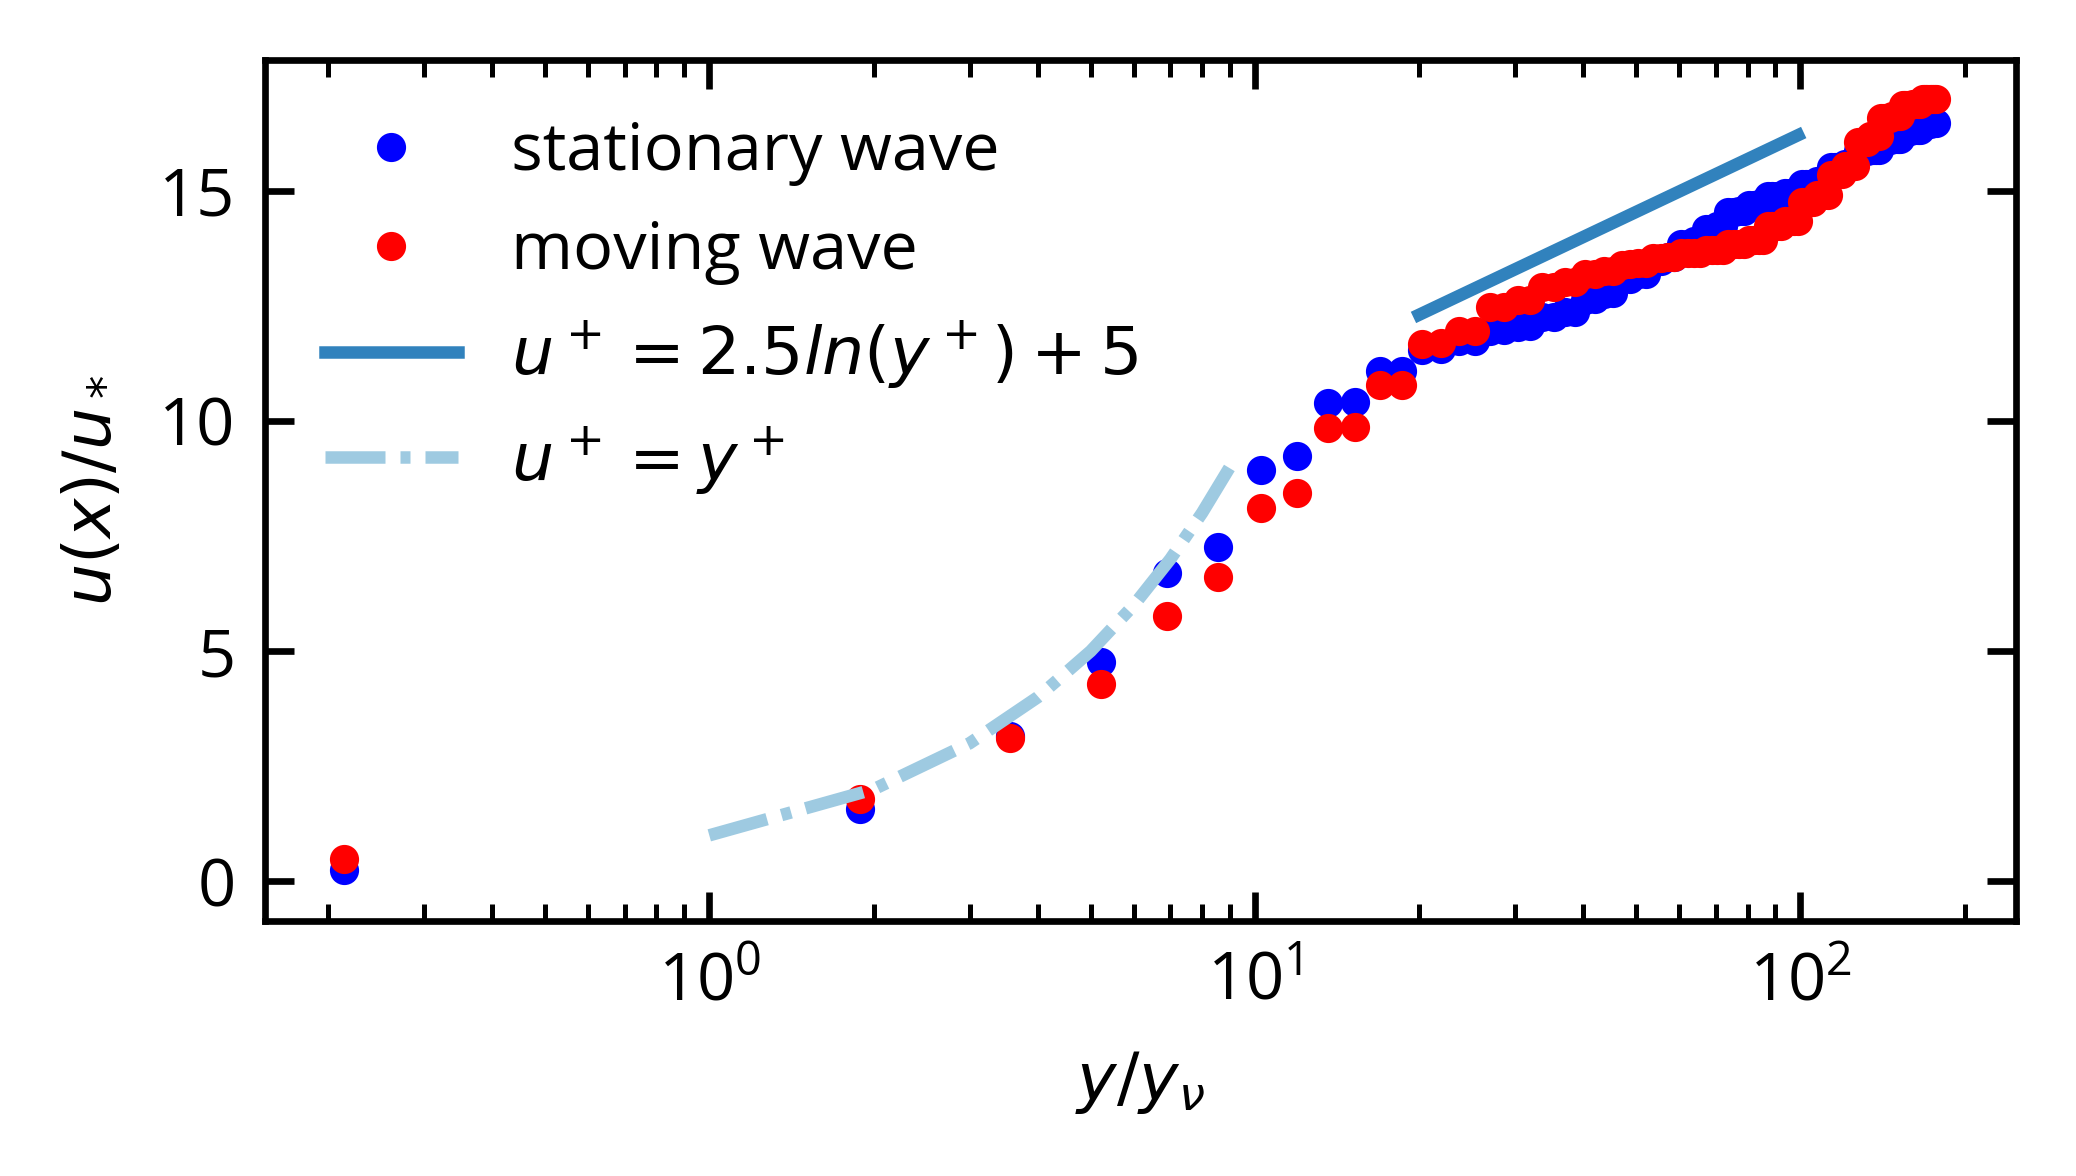

In [86]:
'''Plotting u (averaged) log scale'''
case = case6
ytau = (2*np.pi-1)/case.Retau
plt.figure(figsize=[3.5,2])
# case.mean_profile([253])
# plt.plot(ux_ensemble_aver[1:-1:3], case.yarray[1:-1:3]*case.k, label=r'$\overline{u}$')
# for i in range(0,time.size):
#     plt.plot((case.yarray[74:-1]-1)/ytau, case.ux_ensemble[i][74:-1]/case.ustar, '.')
ux_ensemble_aver = np.average(ux_shift[5:10], axis=(0,1))
re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
plt.plot((case.yarray[31:-1:2]-1)/ytau, ux_ensemble_aver[31:-1:2]/case.ustar, '.', 
         label = 'stationary wave', color='blue')
ux_ensemble_aver = np.average(ux_shift[15:20], axis=(0,1))
re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
plt.plot((case.yarray[31:-1:2]-1)/ytau, ux_ensemble_aver[31:-1:2]/case.ustar, '.', 
         label = 'moving wave', color='red')
y = np.arange(20,100)
plt.plot(y, 1/0.41*np.log(y)+5, label=r'$u^+=2.5ln(y^+)+5$', color=plt.get_cmap('tab20c')(0))
y = np.arange(1,10)
plt.plot(y, y, '-.', label=r'$u^+=y^+$', color=plt.get_cmap('tab20c')(2))
plt.xscale('log'); plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend()

In [ ]:
'''Plotting u (phase averaged)'''
x = np.average(x_tile,axis=0)
fig = plt.figure(figsize=(3,3.5))
# plt.figure(figsize=(1,1))
ux_ensemble_aver = np.tile(np.average(ux_shift, axis=(0,1)), (ux_3D['value'].shape[1], 1)) # 2D tile of the 1D profile
ux_phase_aver = np.average(ux_shift, axis=(0))
img = plt.imshow(np.rot90((ux_phase_aver-ux_ensemble_aver)/0.25),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=0.8,vmin=-0.8)
# plt.imshow(np.rot90(uy_3D['value'][128]/0.25),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=1,vmin=-1)
plt.plot(x,eta_1D_shift,color='k',lw=0.5)
plt.axis('off')
# plt.title('Phase averaged')
cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
cbar.ax.text(-0.9, 0.15, r'$\tilde{u}/u_*$', ha='center', va='center')

In [ ]:
'''Plotting u (instantaneous)'''
x = np.average(x_tile,axis=0)
fig = plt.figure(figsize=(3,3.5)); ax = fig.gca()
img = ax.imshow(np.rot90(ux_shift[0][128]-ux_phase_aver)/0.25,cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=0.8,vmin=-0.8)
# img = ax.imshow(np.rot90(ux_shift[0][128]),cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi],vmax=4,vmin=0)
ax.plot(x,eta_1D_shift,color='k',lw=0.5)
ax.axis('off')
cbar = fig.colorbar(img, orientation="horizontal", pad=0.01)
cbar.ax.text(-0.9, 0.15, r'$u\'/u_{*}$', ha='center', va='center')
# cbar.ax.text(-0.2, 0.5, r'$u$', ha='center', va='center')
# plt.title('Instantaneous fluctuation')

Text(0.5, 1.0, 'Time scales ($u_*/c=0.50$, $Re_w$ = 6415)')

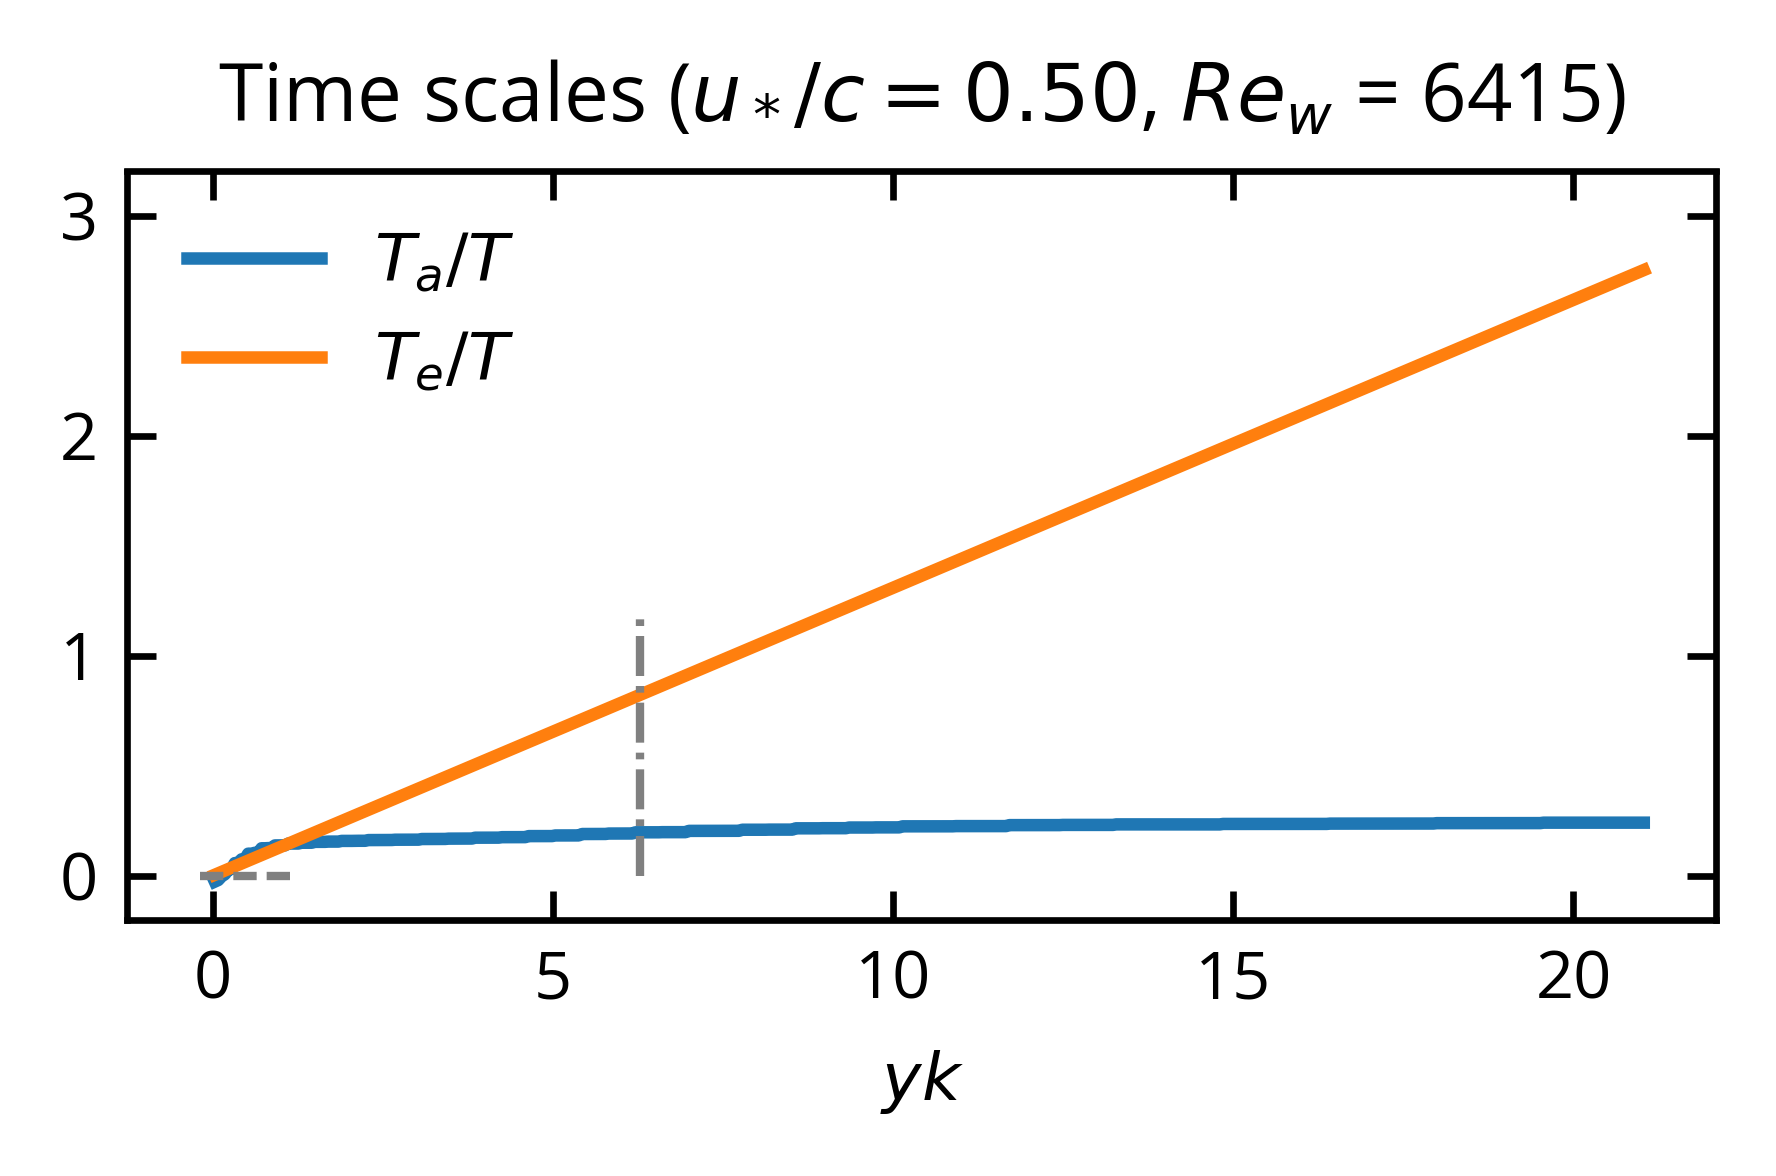

In [113]:
'''Comparison of time scale'''
plt.figure(figsize=[3,2])
case = case3
# case.mean_profile([253])
ux_ensemble_aver = np.average(ux_shift, axis=(0,1))
T_wave = 2*np.pi/case.wave.omega
start = 82
plt.plot((case.yarray[start:-1]-1)*case.k, 1/case.k*(case.ux_ensemble_aver[start:-1]-case.wave.c)/T_wave, label=r'$T_a/T$')
plt.plot((case.yarray[start:-1]-1)*case.k, 0.41*(case.yarray[start:-1]-1)/case.ustar/T_wave, label=r'$T_e/T$')
# plt.plot((case.yarray[74:-1]-1)/ytau, case.yarray[74:-1]/case.yarray[74:-1]*2*np.pi/case.wave.omega, label = r'$T$')
plt.plot(np.linspace(-0.2,1.2,100), np.zeros(100), '--', lw=1, c = 'gray')
plt.plot(np.ones(100)*2*np.pi, np.linspace(0,1.2,100),'-.', lw=1, c = 'gray')
plt.legend(); plt.xlabel(r'$yk$'); plt.ylim([-0.2,3.2])
# plt.xlim([0,20]); plt.ylim([0,2])
plt.title('Time scales ($u_*/c=%.2f$, $Re_w$ = %.f)' %(case.ustar/case.wave.c, case.wave.Re_wave))

In [ ]:
'''Plot the mean (not changing in the first 5)'''
case = case6
case.N = 256
time = np.arange(250,259)
case.mean_profile(time)
# case = case1 ...
ytau = (2*np.pi-1)/case.Retau
plt.figure(figsize=[3.5,2])
# for i in range(0,time.size):
#     plt.plot((case.yarray[74:-1]-1)/ytau, case.ux_ensemble[i][74:-1]/case.ustar, '.')
plt.plot((case.yarray[74:-1]-1)/ytau, case.ux_ensemble_aver[74:-1]/case.ustar, '.')
y = np.arange(40,200)
plt.plot(y, 1/0.41*np.log(y), label=r'$u^+=\frac{1}{\kappa}log(y^+), \kappa=0.41$')
y = np.arange(1,10)
plt.plot(y, y, label=r'$u^+=y^+$')
plt.xscale('log'); plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend()

In [ ]:
def shape_input(N, snapshot):
    x = np.reshape(np.array(snapshot.x), (N,N,N))
    y = np.reshape(np.array(snapshot.y), (N,N,N))
    z = np.reshape(np.array(snapshot.z), (N,N,N))
    ux = np.reshape(np.array(snapshot['u.x']), (N,N,N))
    uy = np.reshape(np.array(snapshot['u.y']), (N,N,N))
    uz = np.reshape(np.array(snapshot['u.z']), (N,N,N))
#     Evis = np.reshape(np.array(snapshot['Evis']), (N,N,N))
    dudy = np.reshape(np.array(snapshot['dudy']), (N,N,N))
    p = np.reshape(np.array(snapshot['p']), (N,N,N))
    gx = np.reshape(np.array(snapshot['g.x']), (N,N,N))
    return x,y,z,ux,uy,uz,dudy,p,gx

In [ ]:
# Plotting statistics like dissipation
filename = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000/stats.dat'
stats2 = pd.read_table(filename, delimiter = ' ')
# plt.plot(stats1.t[2:], stats1.energy[2:])
plt.plot(stats2.t, stats2.dissipation)

In [ ]:
# Calculate ustar from first grid shear
# and an estimation of relevant scales
print(slope_ensemble)
nu = 2*np.pi/40000/(1/850)*(17.4e-6/8.9e-4)
dudy = 1.32
tau = dudy*nu
aH = (2*np.pi-1)*0.001
print('stress from viscous sublayer = %g' %tau)
print('stress from pressure gradient = %g' %aH)
delta_nu = nu/aH**0.5
print('viscous length scale = %g' %delta_nu)
delta_grid = 2*np.pi/2**8
print('grid spacing = %g' %delta_grid)
H = 2*np.pi-1
print('RE_tau = %g' %(H/delta_nu))
ustar = tau**0.5
print('ustar = %g' %ustar)

In [ ]:
# An estimation of scales and needed resolution
nu = 17.4e-6/(1000/850)
a = 0.0001
H = 0.5
ustar = (a*H)**0.5
ustar = 0.1
print('ustar = %g' %ustar)
delta_nu = nu/ustar
print('viscous length scale = %g' %delta_nu)
delta_grid = H/2**12
print('grid spacing = %g' %delta_grid)
print('RE_tau = %g' %(H/delta_nu))

In [ ]:
# Uniform grid data read-in: directly sort and reshape
t = 55
filename = "/home/jiarong/research/projects/turbulence/curved_uniform_forcing_RE4000_LEVEL17_LEVEL24/field_%g" % t
snapshot = pd.read_table(filename, delimiter = ',')
snapshot = snapshot.sort_values(by = ['x','y','z'])
x,y,z,ux,uy,uz,dudy,p,gx = shape_input(2**8,snapshot)

In [ ]:
# AMR grid data read-in: read in by slices
t = 55; sn = 32
NGRID = 256
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0.1_LEVEL9/'
filename = dirname + 'ux_t%g_slice%g' %(t,sn)
snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
snapshot.reshape([NGRID,NGRID+1])
ux = snapshot[:,0:NGRID].astype(np.float)

fig, grid = contour_generator()
image = np.rot90(ux)
pcontour = grid[0].imshow(image, extent=[-np.pi,np.pi,0,2*np.pi])
grid[0].cax.colorbar(pcontour)  

### plot the interface ###
filename = dirname + 'eta_t%g' % t
snapshot = pd.read_table(filename, delimiter = ',')
# Interpolate over x-z plane
xarray = np.arange(-np.pi,np.pi,0.1); zarray = np.arange(-np.pi,np.pi,0.1)
x_tile, z_tile = np.meshgrid(xarray,zarray)
xdata = np.array(snapshot.x); zdata = np.array(snapshot.z); etadata = np.array(snapshot.pos)
eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='nearest')
eta_x = np.average(eta_tile, axis=0)
# The following line if it's fixed eta
# eta_x = 0.1*np.sin(4*xarray)+1
grid[0].plot(xarray,eta_x, color='k')

In [ ]:
'''Fitting local max for wave energy'''
from scipy.signal import argrelextrema
localmax_index = argrelextrema(energy_t, np.greater)[0]
index = np.zeros(1); index = np.append(index, localmax_index); index = index.astype(int)
localmax_time = time[index]
localmax = energy_t[index]
a, b = np.polyfit(localmax_time[0:3], np.log(localmax[0:3]), 1)
omega = 2*np.pi/3.13377
# ax2.plot(time, np.exp(b)*np.exp(a*time)/energy_t[0], linestyle='-.', label = r'$u_{*}/c=%0.1f, \overline{\beta}=%2.4f$' %(0.5,(a/omega)))
# ax2.legend()

In [124]:
def draw_eta(t,ax):
    xarray = np.arange(-np.pi,np.pi,0.05); zarray = np.arange(-np.pi,np.pi,0.05)
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    filename = dirname + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    # Interpolate over x-z plane
    xdata = np.array(snapshot.x); zdata = np.array(snapshot.z); etadata = np.array(snapshot.pos)
    eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='nearest')
    pcontour = ax.imshow((eta_tile-1)*4, vmax = 0.4, vmin=-0.4); 
    ax.cax.colorbar(pcontour) 
    # pcontour.colorbar()

In [ ]:
plt.rcParams['figure.dpi'] = 100

# Single animation generation function
def plot_animation(frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate   
    global dirname
    fig = plt.figure(figsize=(12,8)) 
    fig, grid = contour_generator()
    draw_eta(47,grid[0])

    # animation function.  This is called sequentially
    def animate(i):
        global dirname
        grid[0].clear(); 
#         ax1.axhline(0.05,ls='--',color='C7')
        t = 47 + i*1
        draw_eta(t,grid[0])
        grid[0].set_title('t = %g' %t)
        return fig

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = False)  
    return anim

NGRID = 256
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0.1_LEVEL9_thinlayer/'
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_03_refinewater/'
anim = plot_animation(frame_number = 44, interval_time = 400) # Specify frame number
HTML(anim.to_html5_video())

In [ ]:
T = 2.13
fig = plt.figure()
ax = fig.gca()
ax.plot(time/T, energy_t/energy_t[0]); ax.plot(time/T, energy_t/energy_t[0], '.'); ax.set_xlabel(r'$t/T$'); ax.set_ylabel(r'$\eta^2/\eta_{0}^2$')

In [ ]:
# Plot u*f contour
def plot_water(t,ax):
    global dirname, NGRID
    xarray = np.arange(-np.pi,np.pi,0.05); zarray = np.arange(-np.pi,np.pi,0.05)
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    filename = dirname + 'eta/eta_t%g' % t
    snapshot = pd.read_table(filename, delimiter = ',')
    # Interpolate over x-z plane
    xdata = np.array(snapshot.x); zdata = np.array(snapshot.z); etadata = np.array(snapshot.pos)
    eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='nearest')
    eta = np.average(eta_tile, axis=0)  
    # Read the velocity
    sn = 16
    filename = dirname + 'field/ux_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    ux = snapshot[:,0:NGRID].astype(np.float)
    filename = dirname + 'field/f_t%g_slice%g' % (t,sn)
    snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
    snapshot.reshape([NGRID,NGRID+1])
    f = snapshot[:,0:NGRID].astype(np.float)
    ux_w = ux*f
#     ux_w = ux
    image = np.rot90(ux_w)
    pcontour = ax.imshow(image, extent=[-np.pi,np.pi,0,2*np.pi], vmax=0.2, vmin=-0.2) 
#     pcontour = ax.imshow(image, extent=[-np.pi,np.pi,0,2*np.pi], vmax = 10, vmin = 0) 
    ax.cax.colorbar(pcontour)  
    ax.cax.set_title('ux_w')
    ax.plot(xarray,eta, color='k')
    return 

In [ ]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

plt.rcParams['figure.dpi'] = 100

# Single animation generation function
def plot_animation(frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate   
    global dirname
    fig = plt.figure(figsize=(12,8)) 
    fig, grid = contour_generator()
    plot_water(47,grid[0])

    # animation function.  This is called sequentially
    def animate(i):
        global dirname
        grid[0].clear(); 
#         ax1.axhline(0.05,ls='--',color='C7')
        t = 47 + i*1
        plot_water(t,grid[0])
        grid[0].set_title('t = %g' %t)
        return fig

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = False)  
    return anim

NGRID = 256
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0.1_LEVEL9_thinlayer/'
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_03_refinewater/'
anim = plot_animation(frame_number = 44, interval_time = 400) # Specify frame number
HTML(anim.to_html5_video())

In [ ]:
def mean_profile(dirname, NGRID, time, ax, ploteach = False):
    yarray = np.linspace(0,2*np.pi,NGRID)
    ux_ensemble = []
    for t in time:
        ux_3D = [] # axis0 in z, axis1 in x, axis2 in y  (in the code)
        for i in range (0,63):
            filename = dirname + 'ux_t%g_slice%g' % (t,i)
            snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
            snapshot.reshape([NGRID,NGRID+1])
            ux = snapshot[:,0:NGRID].astype(np.float)
            ux_3D.append(ux)
        ux_3D = np.array(ux_3D)
        ux_aver = np.zeros(NGRID)
        # Slice in x,z(y) plane and average
        for i in range(0,NGRID):
            ux_aver[i] = np.average(ux_3D[:,:,i])
        ux_ensemble.append(ux_aver)
        if (ploteach==True):
            ax.plot(ux_aver, (yarray-1)/(2*np.pi/4), color='gray')
            ax.plot(ux_aver, (yarray-1)/(2*np.pi/4), label = 't=%g' %t)
    ux_ensemble_aver = np.average(np.array(ux_ensemble), axis = 0)
    return ux_ensemble_aver

In [ ]:
### Before and after wave
RATIO = 0.5
nu = 0.001176; c = 0.5; ustar = RATIO*c
ytau = nu/ustar
print('ytau = %g' %ytau)
fig = plt.figure(); ax = fig.gca()
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0.1_LEVEL9_thinlayer/'
NGRID = 256; time = np.arange(50,55,1)
ux_level9 = mean_profile(dirname, NGRID, time, ax)
yarray = np.linspace(0,2*np.pi,NGRID)
ax.plot((yarray-1)/ytau, ux_level9/ustar, '.', label='t = 50-55, no wave', color='C1', linewidth=4)
NGRID = 256; time = np.arange(70,75,1)
ux_level9 = mean_profile(dirname, NGRID, time, ax)
yarray = np.linspace(0,2*np.pi,NGRID)
ax.plot((yarray-1)/ytau, ux_level9/ustar, '.', label='t = 70-75', color='C2', linewidth=4)
NGRID = 256; time = np.arange(90,95,1)
ux_level9 = mean_profile(dirname, NGRID, time, ax)
yarray = np.linspace(0,2*np.pi,NGRID)
ax.plot((yarray-1)/ytau, ux_level9/ustar, '.', label='t = 90-95', color='C3', linewidth=4)
# Plot fit
ypart = np.arange(20,100)
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.41
# ax.plot(ypart, upart, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+), \; \kappa=0.41$')
ax.legend()
ax.set_xlim([1,1500])
ax.set_xscale('log')
ax.set_xlabel(r'$y^+$'); ax.set_ylabel(r'$u^+$')

In [ ]:
# ak = 0.1 vs flat
fig = plt.figure(); ax = fig.gca()
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0_LEVEL8/'
NGRID = 128; time = np.arange(13,18,1)
ux1 = mean_profile(dirname, NGRID, time, ax)
yarray = np.linspace(0,2*np.pi,NGRID)
ax.plot((yarray-1)/ytau, ux1/ustar, '.', label='ak=0', color='C1', linewidth=4)
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0.1_LEVEL9_thinlayer/'
NGRID = 256; time = np.arange(70,80,1)
ux2 = mean_profile(dirname, NGRID, time, ax)
yarray = np.linspace(0,2*np.pi,NGRID)
ax.plot((yarray-1)/ytau, ux2/ustar, '.', label='ak=0.2', color='C2', linewidth=4)

dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0_LEVEL9_leveltest1/'
NGRID = 256; time = np.arange(27.1,27.9,0.1)
ux3 = mean_profile(dirname, NGRID, time, ax)
yarray = np.linspace(0,2*np.pi,NGRID)
ax.plot((yarray-1)/ytau, ux3/ustar, '.', label='true level 9', color='C3', linewidth=4)

RATIO = 0.2
# nu = 0.001176
nu = 0.001176; c = 0.5; ustar = RATIO*c
ytau = nu/ustar
print('ytau = %g' %ytau)
ypart = np.arange(80,400)
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.41+20
ax.plot(ypart, upart, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+), \; \kappa=0.41$')
ax.legend()
ax.set_xlim([0.2,500])
ax.set_xscale('log')
ax.set_xlabel(r'$y^+$'); ax.set_ylabel(r'$u^+$')

In [ ]:
fig = plt.figure(); ax = fig.gca()
ax.plot((yarray-1)/ytau, ux3/ustar, '.', label='level 9', color='C3', linewidth=4)
ypart = np.arange(80,400)
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.41
ax.plot(ypart, upart, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+), \; \kappa=0.41$')
xvisc = np.arange(0,30)
uvisc = xvisc
ax.plot(xvisc,uvisc)
ax.set_xlim([0.2,500])
ax.set_xscale('log')
ax.legend()

### Finally reasonable fit
u*/c = 0.5 has reasonable fit with A = 5 while u*/c = 0.2 might be a bit off.

In [ ]:
# Read in level 8 and 9, u*/c = 0.5
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0_LEVEL8/'
NGRID = 256; time = np.arange(5,17,1)
ux1 = mean_profile(dirname, NGRID, time, ax)
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0_LEVEL9_leveltest1/'
NGRID = 256; time = np.arange(15,17,0.1)
ux2 = mean_profile(dirname, NGRID, time, ax)

In [ ]:
# Trying to fit u*/c = 0.5
plt.rcParams['font.size'] = 14
fig = plt.figure(); ax = fig.gca()
ypart = np.arange(40,200)
RATIO = 0.5
# nu = 0.001176
nu = 0.001735; c = 0.74; ustar = RATIO*c
ytau = nu/ustar
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.4 + 5
ax.plot((yarray-1)/ytau, ux1/ustar, '.', label='MAXLEVEL 8', linewidth=4)
ax.plot((yarray-1)/ytau, ux2/ustar, '.', label='MAXLEVEL 9', linewidth=4)
ax.plot(ypart, upart, label = r'$u^+ = \;2.5*ln(y^+) + 5 $')
# ax.plot(ypart, upart+12, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+) + 12, \; \kappa=0.41$')
# ax.plot((np.ones(ux2.size)*1.5-1)/z0, ux2/ustar, '--', color = 'grey')
# ax.plot((np.ones(ux2.size)*4-1)/z0, ux2/ustar, '--',  color = 'grey')
xvisc = np.arange(1,10)
uvisc = xvisc
ax.plot(xvisc,uvisc, label = '$u^{+} = y^{+}$', color = 'C3')
ax.set_xlim([0.2,400])
ax.set_xscale('log')
ax.legend(loc = 'upper left')
ax.set_xlabel(r'$y^+$'); ax.set_ylabel(r'$u^+$')
fig.savefig('average.svg',bbox_inches='tight')

In [ ]:
# Read in level 9, u*/c = 0.2
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0_LEVEL9_leveltest1/'
NGRID = 256; time = np.arange(27.4,28.4,0.1)
ux3 = mean_profile(dirname, NGRID, time, ax)

In [ ]:
# Try to fit level 9, u*/c = 0.2
fig = plt.figure(); ax = fig.gca()
ypart = np.arange(20,100)
RATIO = 0.2
# nu = 0.001176
nu = 0.001735; c = 0.74; ustar = RATIO*c
ytau = nu/ustar
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.41 + 5
ax.plot((yarray-1)/ytau, ux3/ustar, '.', label='level 9', linewidth=4)
ax.plot(ypart, upart, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+)+5, \; \kappa=0.41$')
# ax.plot(ypart, upart+12, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+) + 12, \; \kappa=0.41$')
ax.plot((np.ones(ux3.size)*1.5-1)/z0, ux3/ustar, '--', color = 'grey')
ax.plot((np.ones(ux3.size)*4-1)/z0, ux3/ustar, '--',  color = 'grey')
xvisc = np.arange(1,10)
uvisc = xvisc
ax.plot(xvisc,uvisc, label = 'linear fit', color = 'C3')
ax.set_xlim([0.2,400])
ax.set_xscale('log')
ax.legend()
ax.set_xlabel(r'$y^+$'); ax.set_ylabel(r'$u^+$')

### LEVEL and uemax

In [ ]:
# # Read in level 8 and 9, u*/c = 0.5
# dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0_LEVEL8/'
# NGRID = 256; time = np.arange(5,17,1)
# ux1 = mean_profile(dirname, NGRID, time, ax)
# dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0_LEVEL9_leveltest1/'
# NGRID = 256; time = np.arange(15,17,0.1)
# ux2 = mean_profile(dirname, NGRID, time, ax)
# Read in level 8, uemaxRATIO=0.3, u*/c = 0.5
# dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0_LEVEL8_03/'
# NGRID = 256; time = np.arange(4,5,0.1)
# ux3 = mean_profile(dirname, NGRID, time, ax)
# dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0_LEVEL8_01/'
# NGRID = 256; time = np.arange(1,2.1,0.1)
# ux4 = mean_profile(dirname, NGRID, time, ax)
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0_LEVEL9_03/'
NGRID = 256; time = np.arange(9,10,0.1)
ux5 = mean_profile(dirname, NGRID, time, ax)

In [ ]:
# Try to fit level 9, u*/c = 0.2
fig = plt.figure(figsize=[10,5]); ax = fig.gca()
ypart = np.arange(30,100)
RATIO = 0.5
# nu = 0.001176
nu = 0.001735; c = 0.74; ustar = RATIO*c
ytau = nu/ustar
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.41 + 5
ax.plot((yarray-1)/ytau, ux2/ustar, '.', label='level 9', linewidth=4)
ax.plot((yarray-1)/ytau, ux1/ustar, '.', label='level 8', linewidth=4)
ax.plot((yarray-1)/ytau, ux3/ustar, '.', label='level 8, uemaxRATIO=0.3', linewidth=4)
ax.plot((yarray-1)/ytau, ux4/ustar, '.', label='level 8, uemaxRATIO=0.1', linewidth=4)
ax.plot((yarray-1)/ytau, ux5/ustar, '.', label='level 9, uemaxRATIO=0.3', linewidth=4)
ax.plot(ypart, upart, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+)+5, \; \kappa=0.41$')
ax.plot(ypart, upart+3, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+)+8, \; \kappa=0.41$')
# ax.plot(ypart, upart+12, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+) + 12, \; \kappa=0.41$')
ax.plot((np.ones(ux3.size)*1.5-1)/z0, ux3/ustar, '--', color = 'grey')
ax.plot((np.ones(ux3.size)*4-1)/z0, ux3/ustar, '--',  color = 'grey')
xvisc = np.arange(1,10)
uvisc = xvisc
ax.plot(xvisc,uvisc, label = 'linear fit', color = 'grey')
ax.set_xlim([0.002,800])
ax.set_xscale('log')
ax.legend()
ax.set_xlabel(r'$y^+$'); ax.set_ylabel(r'$u^+$')

In [ ]:
### u*/c = 0.05 vs 0.2 ###
# u*/c = 0.05
RATIO = 0.05
nu = 0.001176; c = 0.5; ustar = RATIO*c
ytau = nu/ustar
print('ytau = %g' %ytau)
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0.1_LEVEL9/'
NGRID = 256; time = np.arange(50,55,1)
ux_level9 = mean_profile(dirname, NGRID, time)
yarray = np.linspace(0,2*np.pi,NGRID)
plt.plot((yarray-1)/ytau, ux_level9/ustar, '.', label='u*/c = 0.05', color='C1', linewidth=4)
ypart = np.arange(80,400)
# u*/c = 0.2
RATIO = 0.2
nu = 0.001176; c = 0.5; ustar = RATIO*c
ytau = nu/ustar
print('ytau = %g' %ytau)
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0.1_LEVEL9/'
NGRID = 256; time = np.arange(50,55,1)
ux_level9 = mean_profile(dirname, NGRID, time)
yarray = np.linspace(0,2*np.pi,NGRID)
plt.plot((yarray-1)/ytau, ux_level9/ustar, '.', label='u*/c = 0.2', color='C2', linewidth=4)
ypart = np.arange(80,400)
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.41
plt.plot(ypart, upart, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+), \; \kappa=0.41$')
plt.legend()
plt.xlim([0.2,500])
plt.xscale('log')
plt.xlabel(r'$y^+$'); plt.ylabel(r'$u^+$')

In [ ]:
### Normalize, extract z0 ###
# Case physical properties
RATIO = 0.2
nu = 0.001176; c = 0.5; ustar = RATIO*c
ytau = nu/ustar
print('ytau = %g' %ytau)
# LEVEL9
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0.1_LEVEL9/'
NGRID = 256; time = np.arange(50,55,1)
ux_level9 = mean_profile(dirname, NGRID, time)
yarray = np.linspace(0,2*np.pi,NGRID)
plt.plot((yarray-1)/ytau, ux_level9/ustar, '.', label='ensemble level 9', color='red', linewidth=4)
# LEVEL 8
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0.1_LEVEL8_testinit/'
NGRID = 128; time = np.arange(45,50,1)
ux_level8 = mean_profile(dirname, NGRID, time)
yarray = np.linspace(0,2*np.pi,NGRID)
plt.plot((yarray-1)/ytau, ux_level8/ustar, '.', label='ensemble level 8', color='black', linewidth=4)
# Plot the fit
ypart = np.arange(80,400)
z0 = ytau
upart = np.log(ypart*ytau/z0)/0.41
plt.plot(ypart, upart, label = r'$u^+ = \;\frac{1}{\kappa} \; ln(y^+), \; \kappa=0.41$')
plt.legend()
plt.xlim([0.2,500])
plt.xscale('log')
plt.xlabel(r'$y^+$'); plt.ylabel(r'$u^+$')

In [ ]:
# Try average by phase

In [ ]:
# A rough sketch of the profile
nu = 0.000629867; c = 0.5; 
RATIO = 0.5; ustar = RATIO*c
ytau = nu/ustar
yarray = np.arange(0,2*np.pi-1,0.01)
plt.plot(yarray[1:], ustar*np.log(yarray[1:]/ytau)/0.41)
RATIO = 0.2; ustar = RATIO*c
ytau = nu/ustar
yarray = np.arange(0,2*np.pi-1,0.01)
plt.plot(yarray[1:], ustar*np.log(yarray[1:]/ytau)/0.41)

In [ ]:
# Turbulent stress
# dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0_LEVEL9_leveltest1/'
# dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0_LEVEL9_leveltest1/'
yarray = np.linspace(0,2*np.pi,NGRID)
# time = np.arange(55,70)
# time = np.arange(14,18,0.5)
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_03_refinewater/'
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL8_03_notmoving/'
NGRID = 256; time = np.arange(20,40,5)
# time = np.arange(27.5,28.4,0.1)
NSLICE = 64
uxuy_ensemble = []
nu = 0.001735; c = 0.74
RATIO = 0.5; ustar = RATIO*c
delta = 2*np.pi - 1
wavelength = 2*np.pi/4

for index,t in enumerate(time): 
    ux_3D = [] # axis0 in z, axis1 in x, axis2 in y  (in the code)
    uy_3D = []
    for sn in range (0,NSLICE-1):
        filename = dirname + 'ux_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        ux = snapshot[:,0:NGRID].astype(np.float)
        ux_3D.append(ux)
        filename = dirname + 'uy_t%g_slice%g' % (t,sn)
        snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
        snapshot.reshape([NGRID,NGRID+1])
        uy = snapshot[:,0:NGRID].astype(np.float)
        uy_3D.append(uy)
    ux_3D = np.array(ux_3D)
    uy_3D = np.array(uy_3D)
    uxuy_aver = np.zeros(NGRID)
    # Slice in x,z(y) plane and average
    for i in range(0,NGRID):
        ux_aver = np.average(ux_3D[:,:,i])
        uy_aver = np.average(uy_3D[:,:,i])
        uxuy = (ux_3D[:,:,i]-ux_aver)*(uy_3D[:,:,i]-uy_aver)
        #uxuy = (ux_3D[:,:,i]-ux_aver)*(ux_3D[:,:,i]-ux_aver)
        uxuy_aver[i] = np.average(uxuy)
    plt.plot(-uxuy_aver/ustar**2, (yarray-1)/wavelength, label='t = %g' %t, color=plt.cm.get_cmap('summer')(1-index/len(time)))
    uxuy_ensemble.append(uxuy_aver)
#     plt.imshow(ux_3D[:,:,32])
#     # Average in z direction
#     for 


uxuy_ensemble = np.array(uxuy_ensemble)    
# plt.plot(np.average(-uxuy_ensemble,axis=0)/ustar**2, (yarray-1)/delta, label='average' %t, color = 'r')
plt.ylim([0,4])
plt.xlim([-0.2,2])
# plt.plot(-uxuy_aver/ustar**2, (np.ones(uxuy_aver.size)*2-1)/delta, '--', color = 'grey')
# plt.plot(-uxuy_aver/ustar**2, (np.ones(uxuy_aver.size)*4-1)/delta, '--', color = 'grey')
plt.xlabel(r'$\overline{u_xu_x}/u_*^2$') 
# plt.ylabel(r'$y/\delta$')
plt.ylabel(r'$y/\lambda$')
plt.legend()
# Laminar shear stress

# ...

In [ ]:
RATIO = 0.5
nu = 0.001735; c = 0.74; ustar = RATIO*c
plt.plot(np.average(-uxuy_ensemble,axis=0)/ustar**2, (yarray-1)/delta, label='average' %t)
plt.ylim([0,1])
plt.plot(-uxuy_aver/ustar**2, (np.ones(uxuy_aver.size)*1.5-1)/delta, '--')
plt.plot(-uxuy_aver/ustar**2, (np.ones(uxuy_aver.size)*4-1)/delta, '--')
plt.xlabel(r'$\overline{-u_xu_y}/u_*^2$'); plt.ylabel(r'$y^+$')
plt.legend()

In [ ]:
name = 'perfs_sum.txt'
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_03_refinewater_precursor/'
perfs1,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_04_refinewater_precursor/'
perfs2,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_05_refinewater_precursor/'
perfs3,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL10_05_refinewater_precursor/'
perfs4,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])

In [ ]:
plt.plot(perfs1.t,perfs1.gridn,label='LEVEL9,uemax=0.3')
plt.plot(perfs2.t,perfs2.gridn,label='LEVEL9,uemax=0.4')
plt.plot(perfs3.t,perfs3.gridn,label='LEVEL9,uemax=0.5')
plt.plot(perfs4.t,perfs4.gridn,label='LEVEL10,uemax=0.5')
a = np.arange(38,70,0.1)
plt.plot(a,np.ones(a.size)*256**3,'--', color='gray',label='2^8^3')
plt.plot(a,np.ones(a.size)*512**3,'--', color='gray',label='2^9^3')
# plt.plot(a,np.ones(a.size)*512**3,'--', color='gray')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.ylabel('grid #')

In [ ]:
plt.plot(perfs1.t,perfs1.dt,label='LEVEL9,uemax=0.3')
plt.plot(perfs2.t,perfs2.dt,label='LEVEL9,uemax=0.4')
plt.plot(perfs3.t,perfs3.dt,label='LEVEL9,uemax=0.5')
plt.plot(perfs4.t,perfs4.dt,'.',label='LEVEL10,uemax=0.5')
plt.legend(loc = 'upper right')
plt.ylabel('grid #')

In [ ]:
filename = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL10_05_refinewater_precursor/prof_43'
stats = pd.read_table(filename, delimiter = '\t', names = ['y','ux','uy','uz','uxuy','uxux','uyuy','uzuz'], skiprows=[0])
y_tau = 1/180; u_tau = 0.74*0.5
plt.plot((stats.y[15:]-1)/y_tau, stats.ux[15:]/u_tau, '.')
y = np.arange(20,100)
plt.plot(y, 2.5*np.log(y)+5.5, label='u+=2.5*np.log(y+)+5.5')
plt.plot(y, 2.5*np.log(y)+5, label='u+=2.5*np.log(y+)+5')
y = np.arange(0.1,10)
plt.plot(y, y, label='u+=y+')
plt.xscale('log')
plt.ylim([0,20])
plt.legend()